# STS: Semantic Textual Similarity
Group #1 (STS) members:
- *Simona Malegori, 10689386*
- *Alberto Pirillo, 10667220*
- *Eleonora Sala, 10680847*
- *Federico Tognoni, 10676136*

# 1. Preliminary Analysis

Install all the missing libraries required to run the notebook:

In [ ]:
!pip install -q sentence_transformers openai tiktoken

## 1.1 Loading Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/NLP_project')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/Colab Notebooks/NLP_project'

In [ ]:
import csv
import re
import plotly.express as px
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()
sns.set(font_scale=2)

In [ ]:
path_train = 'data/sts-train.csv'
path_dev = 'data/sts-dev.csv'
path_test = 'data/sts-test.csv'

In [ ]:
columns=['genre', 'file', 'year', 'index', 'score', 'sentence1', 'sentence2']

In [ ]:
df_train = pd.read_csv(path_train, sep='\t', usecols=range(7), header=None, quoting=csv.QUOTE_NONE, names=columns, encoding='UTF-8')
df_dev = pd.read_csv(path_dev, sep='\t', usecols=range(7), header=None, quoting=csv.QUOTE_NONE, names=columns, encoding='UTF-8')
df_test = pd.read_csv(path_test, sep='\t', usecols=range(7), header=None, quoting=csv.QUOTE_NONE, names=columns, encoding='UTF-8')

In [ ]:
df = pd.concat([df_train, df_dev, df_test]).reset_index(drop=True)
df

genre       file      year  index  score  \
0     main-captions     MSRvid  2012test      1   5.00   
1     main-captions     MSRvid  2012test      4   3.80   
2     main-captions     MSRvid  2012test      5   3.80   
3     main-captions     MSRvid  2012test      6   2.60   
4     main-captions     MSRvid  2012test      9   4.25   
...             ...        ...       ...    ...    ...   
8623      main-news  headlines      2016   1354   0.00   
8624      main-news  headlines      2016   1360   1.00   
8625      main-news  headlines      2016   1368   1.00   
8626      main-news  headlines      2016   1420   0.00   
8627      main-news  headlines      2016   1432   0.00   

                                              sentence1  \
0                                A plane is taking off.   
1                       A man is playing a large flute.   
2         A man is spreading shreded cheese on a pizza.   
3                          Three men are playing chess.   
4                           A man is playing the cello.   
...                                                 ...   
8623  Philippines, Canada pledge to further boost re...   
8624  Israel bars Palestinians from Jerusalem's Old ...   
8625         How much do you know about Secret Service?   
8626  Obama Struggles to Soothe Saudi Fears As Iran ...   
8627          South Korea declares end to MERS outbreak   

                                              sentence2  
0                           An air plane is taking off.  
1                             A man is playing a flute.  
2     A man is spreading shredded cheese on an uncoo...  
3                            Two men are playing chess.  
4                    A man seated is playing the cello.  
...                                                 ...  
8623            Philippines saves 100 after ferry sinks  
8624  Two-state solution between Palestinians, Israe...  
8625  Lawmakers from both sides express outrage at S...  
8626  Myanmar Struggles to Finalize Voter Lists for ...  
8627  North Korea Delegation Meets With South Korean...  

[8628 rows x 7 columns]

## 1.2 Dataset description
The dataset, i.e. STS Benchmark dataset, is composed of 3 sets of data:
- train
- development
- test

The dataset contains **sentences** coming from 3 different type of sources:
- image captions,
- news headlines,
- user forums

Each row of the dataset contains (only relevant columns are mentioned here):
- `genre`: the type of the source
- `year`
- `a pair of sentences`, to be compared on the similarity between their meaning (i.e. semantic similarity)
- `score`: an index, assigned by humans in the range from 0 to 5, of the similarity of the two sentences. 

In the following cell we compute the size of the dataset:

In [ ]:
print(f'Number of pairs of sentences: {len(df)}')
print(f'Total number of sentences: {len(df)*2}')

Number of pairs of sentences: 8628
Total number of sentences: 17256


We see that our dataset, considering train, dev and test, contains 8628 pairs of sentences, each of them with a genre, a year and a score.

## 1.3 Data cleaning

First of all, we need to assess the quality of the data at our disposal and determine whether some pre-processing steps need to be performed.

We start by checking for null values:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8628 entries, 0 to 8627
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   genre      8628 non-null   object 
 1   file       8628 non-null   object 
 2   year       8628 non-null   object 
 3   index      8628 non-null   int64  
 4   score      8628 non-null   float64
 5   sentence1  8628 non-null   object 
 6   sentence2  8628 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 472.0+ KB


There are no null values.

Now we focus on the columns. The values of some them are inconsistent or contain unnecessary information. We can use regular expressions to obtain a consistent format.

In [ ]:
df['genre'].value_counts()

main-news        4299
main-captions    3250
main-forums       629
main-forum        450
Name: genre, dtype: int64

In [ ]:
df['year'].value_counts()

2014         2250
2015         1875
2012test     1500
2012train    1500
2013          750
2016          503
2017          250
Name: year, dtype: int64

In [ ]:
df['genre'] = df['genre'].replace('main-', '', regex=True)
df['genre'] = df['genre'].replace('forum', 'forums')
df['year'] = df['year'].replace(r'\D', '', regex=True)

In [ ]:
df['genre'].value_counts()

news        4299
captions    3250
forums      1079
Name: genre, dtype: int64

In [ ]:
df['year'].value_counts()

2012    3000
2014    2250
2015    1875
2013     750
2016     503
2017     250
Name: year, dtype: int64

The similarity scores in the dataset are contained in the range $[0,5]$. We want to rescale them so that they belong to the range $[0,1]$. 

This will allow for a more direct comparison with the results of our models.

We can do this through a `MinMaxScaler` from `scikit-learn`:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['score'] = scaler.fit_transform(df[['score']])

The following is the head of the dataframe we are actually going to use:

In [ ]:
df

genre       file  year  index  score  \
0     captions     MSRvid  2012      1   1.00   
1     captions     MSRvid  2012      4   0.76   
2     captions     MSRvid  2012      5   0.76   
3     captions     MSRvid  2012      6   0.52   
4     captions     MSRvid  2012      9   0.85   
...        ...        ...   ...    ...    ...   
8623      news  headlines  2016   1354   0.00   
8624      news  headlines  2016   1360   0.20   
8625      news  headlines  2016   1368   0.20   
8626      news  headlines  2016   1420   0.00   
8627      news  headlines  2016   1432   0.00   

                                              sentence1  \
0                                A plane is taking off.   
1                       A man is playing a large flute.   
2         A man is spreading shreded cheese on a pizza.   
3                          Three men are playing chess.   
4                           A man is playing the cello.   
...                                                 ...   
8623  Philippines, Canada pledge to further boost re...   
8624  Israel bars Palestinians from Jerusalem's Old ...   
8625         How much do you know about Secret Service?   
8626  Obama Struggles to Soothe Saudi Fears As Iran ...   
8627          South Korea declares end to MERS outbreak   

                                              sentence2  
0                           An air plane is taking off.  
1                             A man is playing a flute.  
2     A man is spreading shredded cheese on an uncoo...  
3                            Two men are playing chess.  
4                    A man seated is playing the cello.  
...                                                 ...  
8623            Philippines saves 100 after ferry sinks  
8624  Two-state solution between Palestinians, Israe...  
8625  Lawmakers from both sides express outrage at S...  
8626  Myanmar Struggles to Finalize Voter Lists for ...  
8627  North Korea Delegation Meets With South Korean...  

[8628 rows x 7 columns]

Now we can define a function to perform the same pre-processing steps in the 3 separated datasets.

In [ ]:
def pre_processing(df_to_process: pd.DataFrame) -> pd.DataFrame:
    df_to_process['genre'] = df_to_process['genre'].replace('main-', '', regex=True)
    df_to_process['genre'] = df_to_process['genre'].replace('forum', 'forums')
    df_to_process['year'] = df_to_process['year'].replace(r'\D', '', regex=True)
    df_to_process['score'] = MinMaxScaler().fit_transform(df_to_process[['score']])
    return df_to_process

In [ ]:
df_train = pre_processing(df_train)
df_dev = pre_processing(df_dev)
df_test = pre_processing(df_test)

## 1.4 Data Visualization

Now that the data is pre-processed, we can plot the most relevant features in our dataset to investigate their distribution.

Before plotting, we can reorder the data to obtain better results.

To avoid modifying the original dataset, we will create a copy and work with that one.

In [ ]:
df_plot = df.copy()
df_plot['genre'] = pd.Categorical(df['genre'], categories=['captions', 'news', 'forums'], ordered=True)
df_plot['file'] = pd.Categorical(df['file'], categories=['MSRvid', 'images', 'track5.en-en', 'MSRpar', 'deft-news', 'headlines', 'deft-forum', 'answers-forums', 'answer-answer' ], ordered=True)

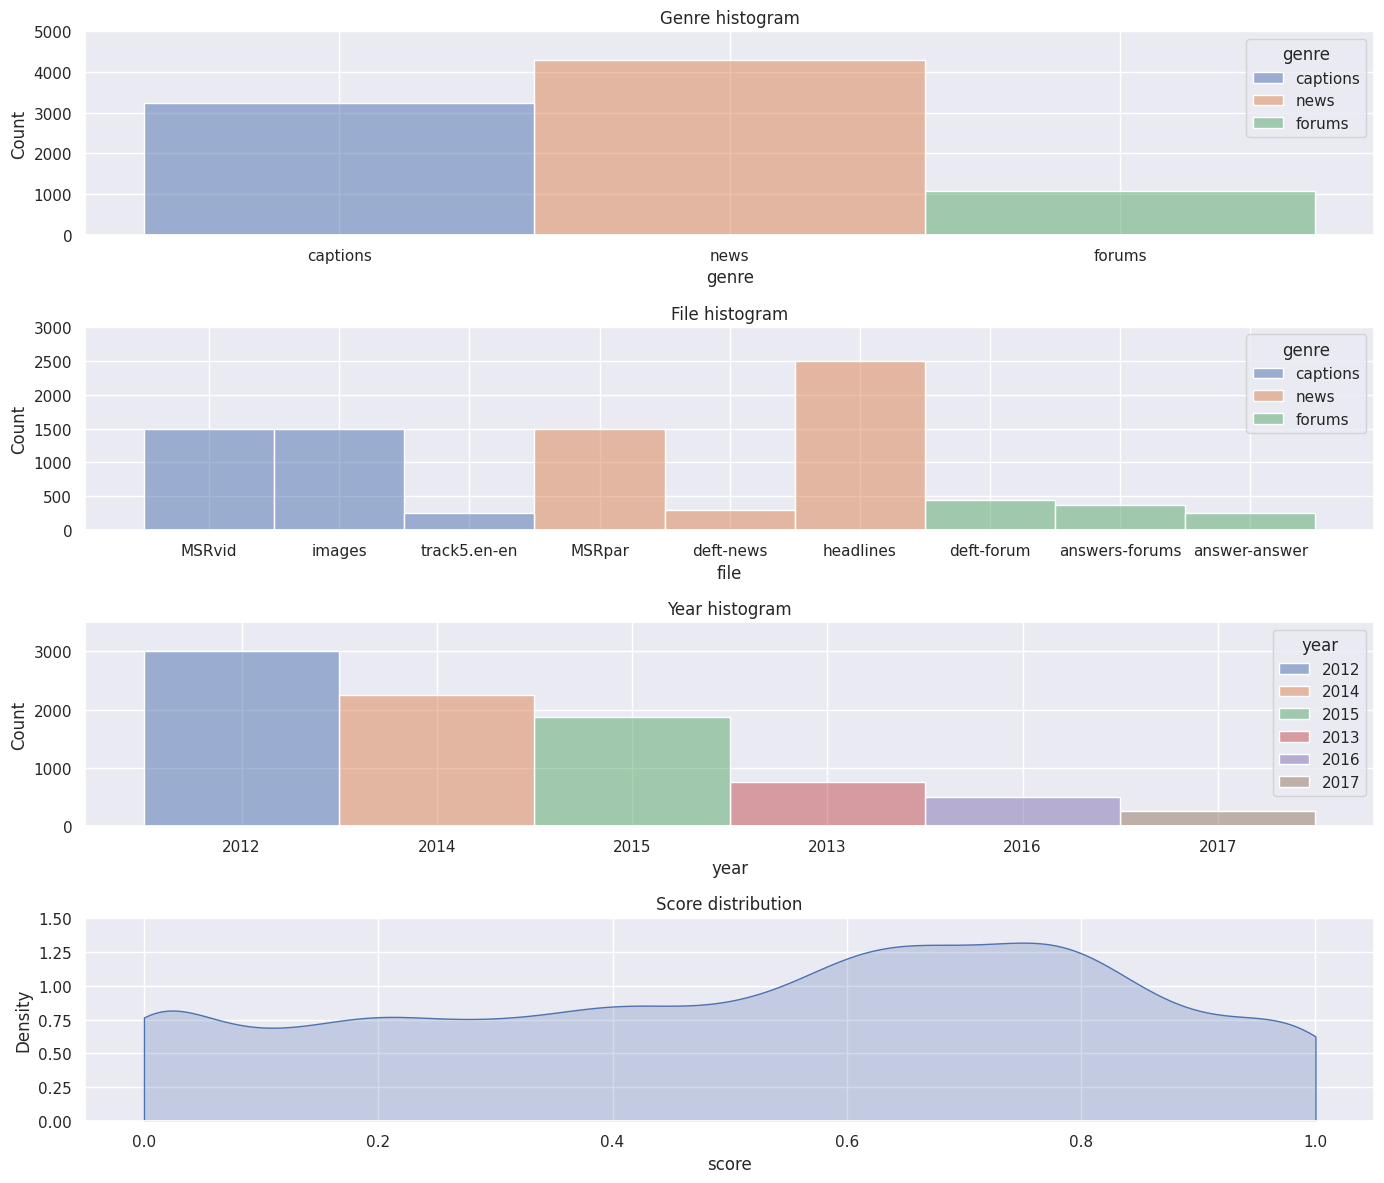

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(14, 12))

axs[0].set_title('Genre histogram')
axs[0].set_ylim(0, 5000)
sns.histplot(data=df_plot, x='genre', hue='genre', ax=axs[0])
axs[1].set_title('File histogram')
axs[1].set_ylim(0, 3000)
sns.histplot(data=df_plot, x='file', hue='genre', ax=axs[1])
axs[2].set_title('Year histogram')
axs[2].set_ylim(0, 3500)
sns.histplot(data=df_plot, x='year', hue='year', ax=axs[2])
axs[3].set_title('Score distribution')
axs[3].set_ylim(0, 1.5)
sns.kdeplot(data=df_plot, x='score', fill=True, clip=(0.0, 1.0), ax=axs[3])

fig.tight_layout()

We can see that the categorical features (genre, file and year) present a very imbalanced distribution. However, this is not an issue since in our analysis we will mainly focus on the score and on the content of the pair of sentences (that will be discussed later).

Regarding the score, which is the only continuous feature, we can see that it does not follow a uniform distribution. This is interesting because scores were manually assigned by human annotators, and it might suggest that humans are more prone to judge two sentences as similar rather than non-similar.

Or, it could just be a property of the subset of sentences chosen to build the dataset.  

## 1.5 Vocabulary Investigation

Now, since our tasks will be focused on text, it is useful to perform some analysis of the characteristics of the sentences contained in the dataset, to better understand the subject we're dealing with.

First of all we can see how long our sentences are, and we do this by first computing the length (i.e. number of characters) of each sentence:

In [ ]:
s1_len = df['sentence1'].apply(lambda x : len(str(x)))
s2_len = df['sentence2'].apply(lambda x : len(str(x)))

Then we can take the average of these values:

In [ ]:
avg_s1_len = s1_len.mean()
avg_s2_len = s2_len.mean()

print(f'Average number of characters of sentences 1: {avg_s1_len}')
print(f'Average number of characters of sentences 2: {avg_s2_len}')

Average number of characters of sentences 1: 58.23528048215113
Average number of characters of sentences 2: 57.9598980064905


We see that on average the sentences have about **58 characters** each.

This gives us a first idea, although when working with sentences it is likely more interesting to know the number of words they contain. Thus, we'll compute also this measure for the sentence's size.

Prior to do so, since we want to focus on words, we need to process a bit the sentences in order to have a cleaner version of them, by lower the text and removing punctuation.

Then we will extract from each sentence the list of its words.

In [ ]:
import string

regex = '[' + string.punctuation + ']' # string.punctuation = !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

In [ ]:
# new dataframe
df_processed = pd.DataFrame(columns=['sentence1', 'sentence2', 'vocab1', 'vocab2'])

# lowercase
df_processed['sentence1'] = df['sentence1'].apply(lambda x : x.lower())
df_processed['sentence2'] = df['sentence2'].apply(lambda x : x.lower())

# removing punctuation (with regex expression), split in words, sort words
df_processed['vocab1'] = df_processed['sentence1'].apply(lambda x: sorted(str(re.sub(regex, '', x)).split()))
df_processed['vocab2'] = df_processed['sentence2'].apply(lambda x: sorted(str(re.sub(regex, '', x)).split()))

Now we can compute the average number of words per sentence:

In [ ]:
avg_vocab1_size = df_processed['vocab1'].apply(lambda x: len(x)).mean()
avg_vocab2_size = df_processed['vocab2'].apply(lambda x: len(x)).mean()

print(f'Average number of words per sentence 1: {avg_vocab1_size}')
print(f'Average number of words per sentence 2: {avg_vocab2_size}')

Average number of words per sentence 1: 10.163885025498377
Average number of words per sentence 2: 10.142095503013445


We see that on average the sentences have about **10 words** each, this means we're dealing in most part with concise sentences.

Now we can continue towards the analysis of the **vocabulary** of the sentences, and subsequently of our dataset.

First by merging the list of words of all sentences, we can compute the size of the vocabularies.

**Vocabulary of `sentence1`**:

In [ ]:
# words of sentences 1
global_vocab1 = df_processed['vocab1'].sum()
print(f'Total number of words (1): {len(global_vocab1)}')
print(f'Vocabulary size (1): {len(set(global_vocab1))}')

Total number of words (1): 87694
Vocabulary size (1): 12521


For the sentences in the column "sentence1" we see that the vocabulary, intended as collection of distinct words, has about 12500 words.

**Vocabulary of `sentence2`**:

In [ ]:
# words of sentences 2
global_vocab2 = df_processed['vocab2'].sum()
print(f'Total number of words (2): {len(global_vocab2)}')
print(f'Vocabulary size (2): {len(set(global_vocab2))}')

Total number of words (2): 87506
Vocabulary size (2): 12514


For the sentences in the column "sentence2" we see that the vocabulary has about 12500 words.

**Vocabulary of `all sentences`** in the dataset:

In [ ]:
global_vocab = global_vocab1 + global_vocab2
print(f'Total number of words: {len(global_vocab)}')
print(f'Vocabulary size: {len(set(global_vocab))}')

Total number of words: 175200
Vocabulary size: 15914


Then we proceed with an analysis on **word's occurrences**.

We will perform this analysis, as before, on the two sentence's columns separately and then jointly on the whole dataset.


First using `nltk` library, we count the occurrences in the vectors that contain all words of the two respective columns:

In [ ]:
import nltk

counts1 = nltk.Counter(global_vocab1)
counts2 = nltk.Counter(global_vocab2)

sns.set_theme()

Then we can visualize the words and their respective frequency in a bar chart:

(for representation purposes we will consider words with frequency higher than 80)

In [ ]:
# filtering words with frequency higher than 80
counts1_filtered = dict(filter(lambda x: x[1] > 80, counts1.items()))
counts2_filtered = dict(filter(lambda x: x[1] > 80, counts2.items()))

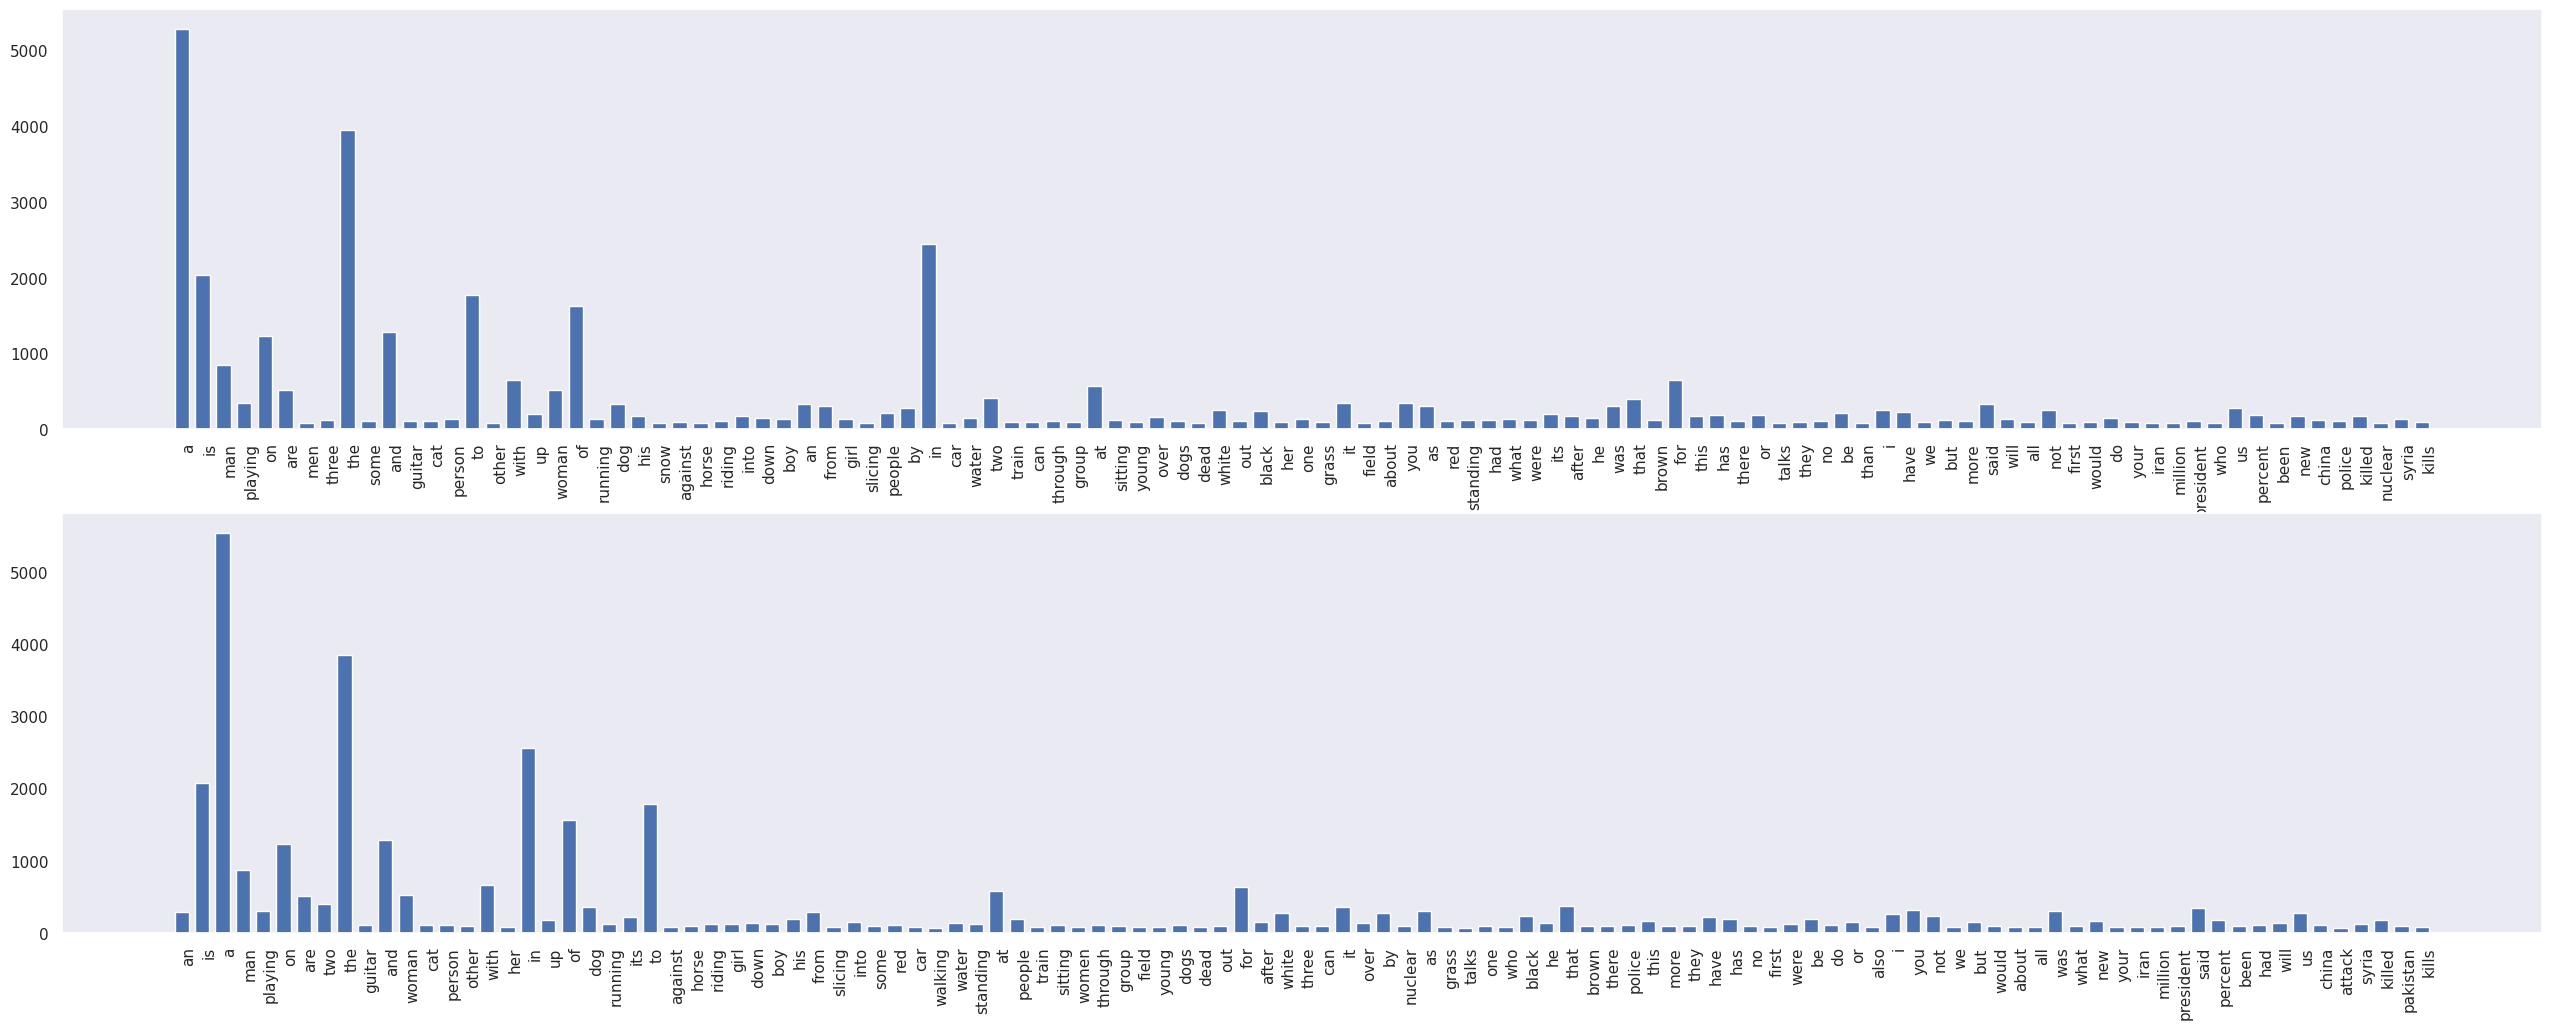

In [ ]:
width = 0.7
_, axs = plt.subplots(2, 1, figsize=(32, 12))
axs[0].bar(np.arange(len(counts1_filtered)), counts1_filtered.values(), width)
axs[0].set_xticks(np.arange(len(counts1_filtered)) + width * 0.5, counts1_filtered.keys(), rotation=90)
axs[0].grid(False)

axs[1].bar(np.arange(len(counts2_filtered)), counts2_filtered.values(), width)
axs[1].set_xticks(np.arange(len(counts2_filtered)) + width * 0.5, counts2_filtered.keys(), rotation=90)
axs[1].grid(False)

We see that in both sets, the words that stand out for number of occurrences are:
`a`, `the`, `to`, `in`, `of`, `on`, `and`. As we could expect stopwords are by far the most frequent in our dataset. 

Despite being highly frequent, stopwords are not very informative, and we may want to remove them to have a better perspective on which meaningful words are most present.

Thus, we proceed by removing stopwords from the sentences vocabularies, and by counting again words occurrences:

In [ ]:
# importing stopwords from nltk library
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary and count of `sentence1` without stopwords:

In [ ]:
# vocabulary 1 without stopwords
vocab1_nostop = [w for w in global_vocab1 if w not in stopwords.words('english')]
counts1_nostop = nltk.Counter(vocab1_nostop)
print(f'Size of vocabulary (1) without stopwords: {len(set(vocab1_nostop))}')

Size of vocabulary (1) without stopwords: 12394


Vocabulary and count of `sentence2` without stopwords:

In [ ]:
# vocabulary 2 without stopwords
vocab2_nostop = [w for w in global_vocab2 if w not in stopwords.words('english')]
counts2_nostop = nltk.Counter(vocab2_nostop)
print(f'Size of vocabulary (2) without stopwords: {len(set(vocab2_nostop))}')

Size of vocabulary (2) without stopwords: 12387


As a side note we notice that in both cases about almost 130 (distinct) words were removed as stopwords.

Then we can visualize the words and their respective frequency in a bar chart:

(for representation purposes we will consider words with frequency higher than 50)

In [ ]:
# filtering words with frequency higher than 50
counts1_nostop_filtered = dict(filter(lambda x: x[1] > 50, counts1_nostop.items()))
counts2_nostop_filtered = dict(filter(lambda x: x[1] > 50, counts2_nostop.items()))

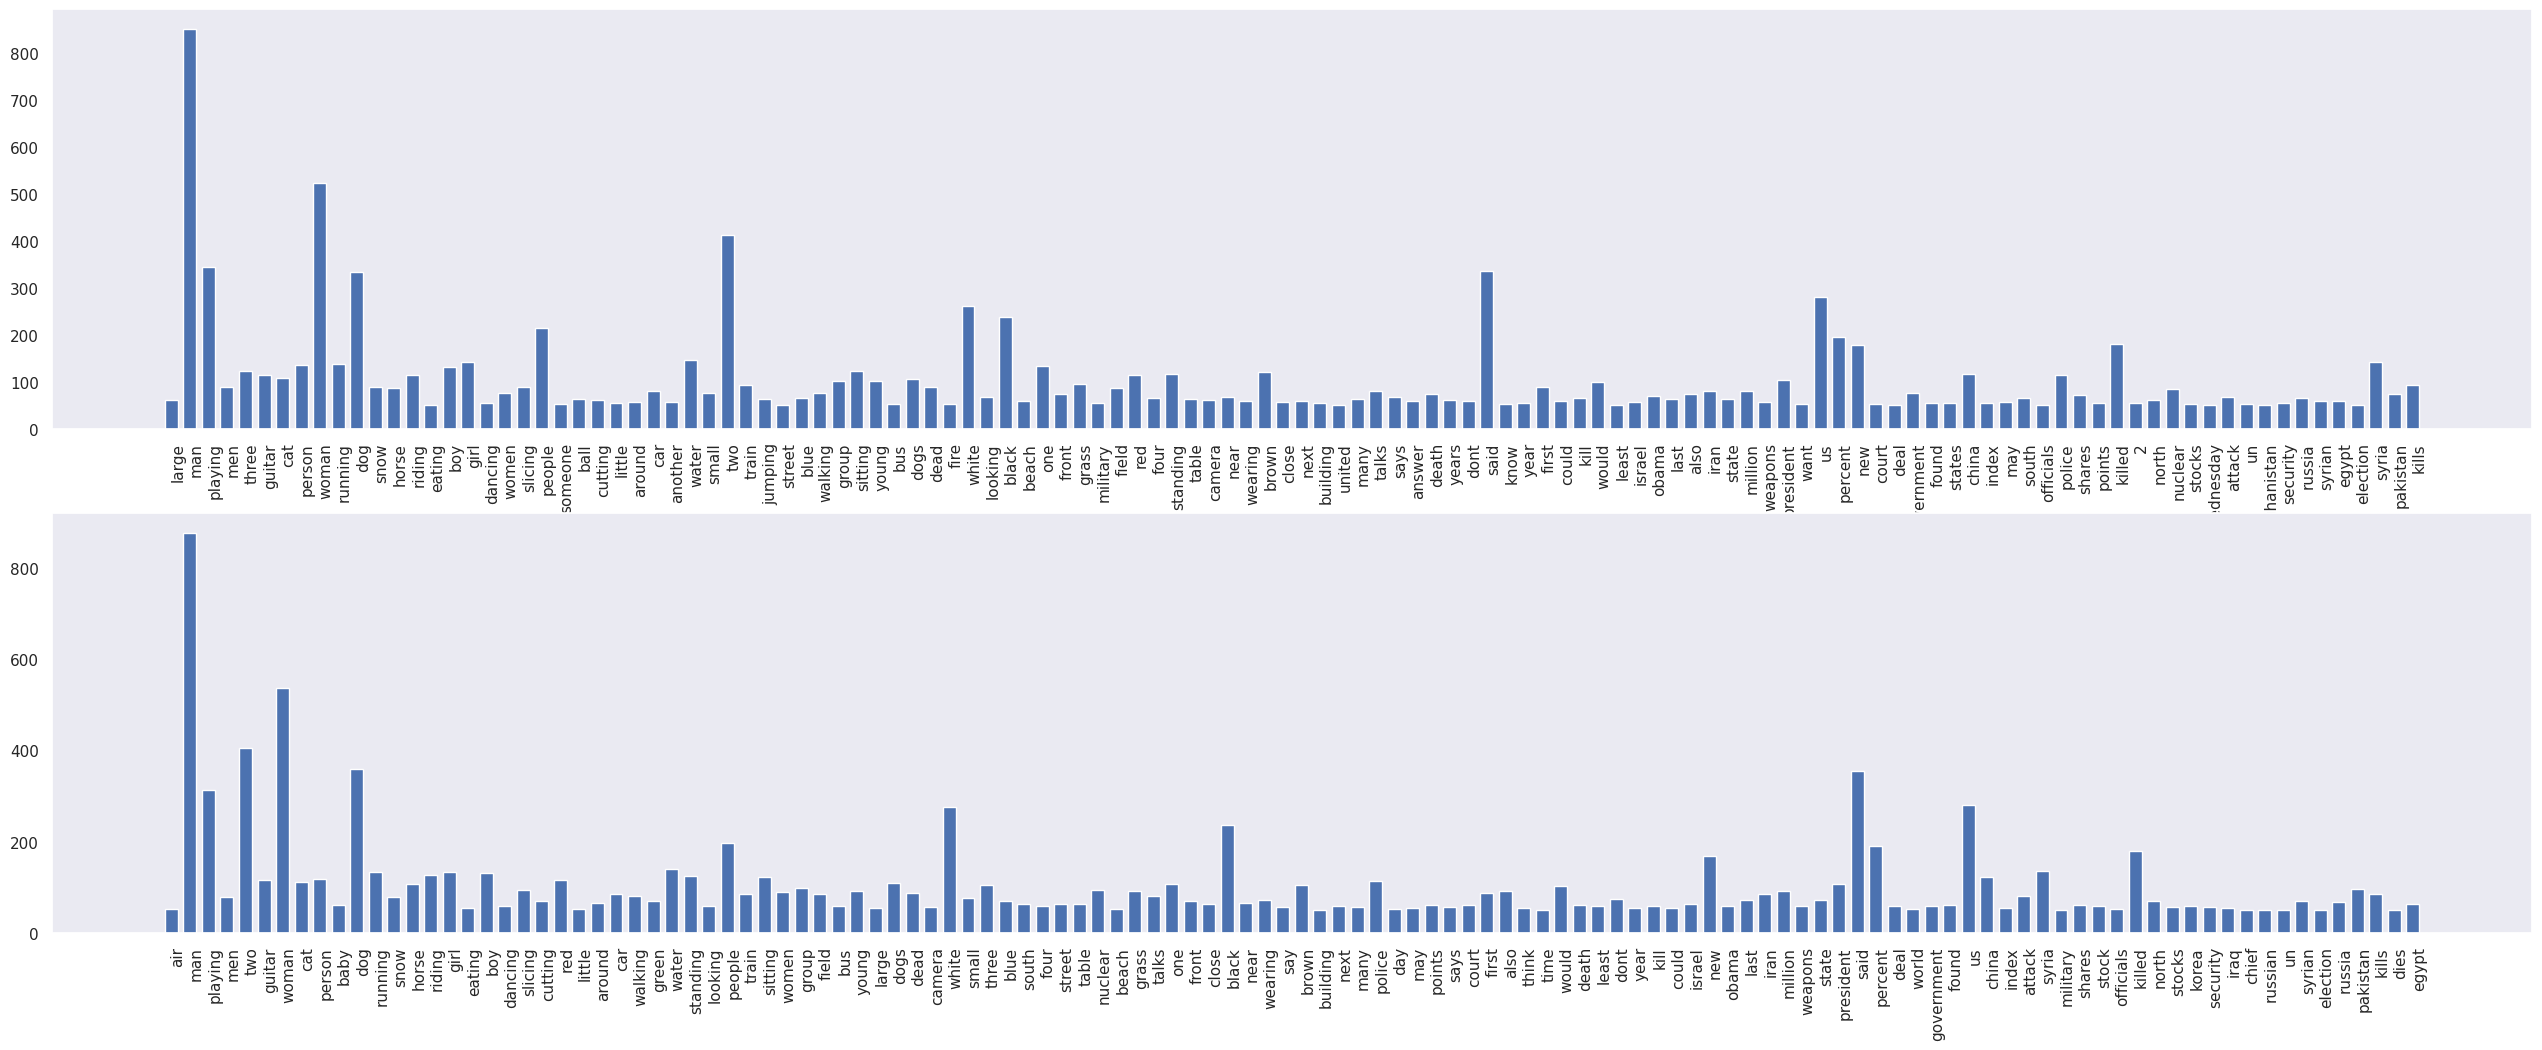

In [ ]:
width = 0.7
_, axs = plt.subplots(2, 1, figsize=(32, 12))
axs[0].bar(np.arange(len(counts1_nostop_filtered)), counts1_nostop_filtered.values(), width)
axs[0].set_xticks(np.arange(len(counts1_nostop_filtered)) + width * 0.5, counts1_nostop_filtered.keys(), rotation=90)
axs[0].grid(False)

axs[1].bar(np.arange(len(counts2_nostop_filtered)), counts2_nostop_filtered.values(), width)
axs[1].set_xticks(np.arange(len(counts2_nostop_filtered)) + width * 0.5, counts2_nostop_filtered.keys(), rotation=90)
axs[1].grid(False)

We can also directly compare the most common words of the two sets (sorted from the first to the 20th most common):

In [ ]:
print(f'Most common (1): \n{list(dict(counts1_nostop.most_common(20)).keys())}')

Most common (1): 
['man', 'woman', 'two', 'playing', 'said', 'dog', 'us', 'white', 'black', 'people', 'percent', 'killed', 'new', 'water', 'girl', 'syria', 'running', 'person', 'one', 'boy']


In [ ]:
print(f'Most common (2): \n{list(dict(counts2_nostop.most_common(20)).keys())}')

Most common (2): 
['man', 'woman', 'two', 'dog', 'said', 'playing', 'us', 'white', 'black', 'people', 'percent', 'killed', 'new', 'water', 'syria', 'girl', 'running', 'boy', 'riding', 'standing']


As a last step we can perform the same analysis on the **whole dataset** of sentences, this time removing stopwords in advance.

In [ ]:
vocab_nostopwords = [w for w in global_vocab if w not in stopwords.words('english')]
counts_nostopwords = nltk.Counter(vocab_nostopwords)

We can visualize the words and their respective frequency in a bar chart:

(for representation purposes we will consider words with frequency higher than 100)

In [ ]:
# considering words with frequency higher than 100
counts_nostopwords_filtered = dict(filter(lambda x: x[1] > 100, counts_nostopwords.items()))

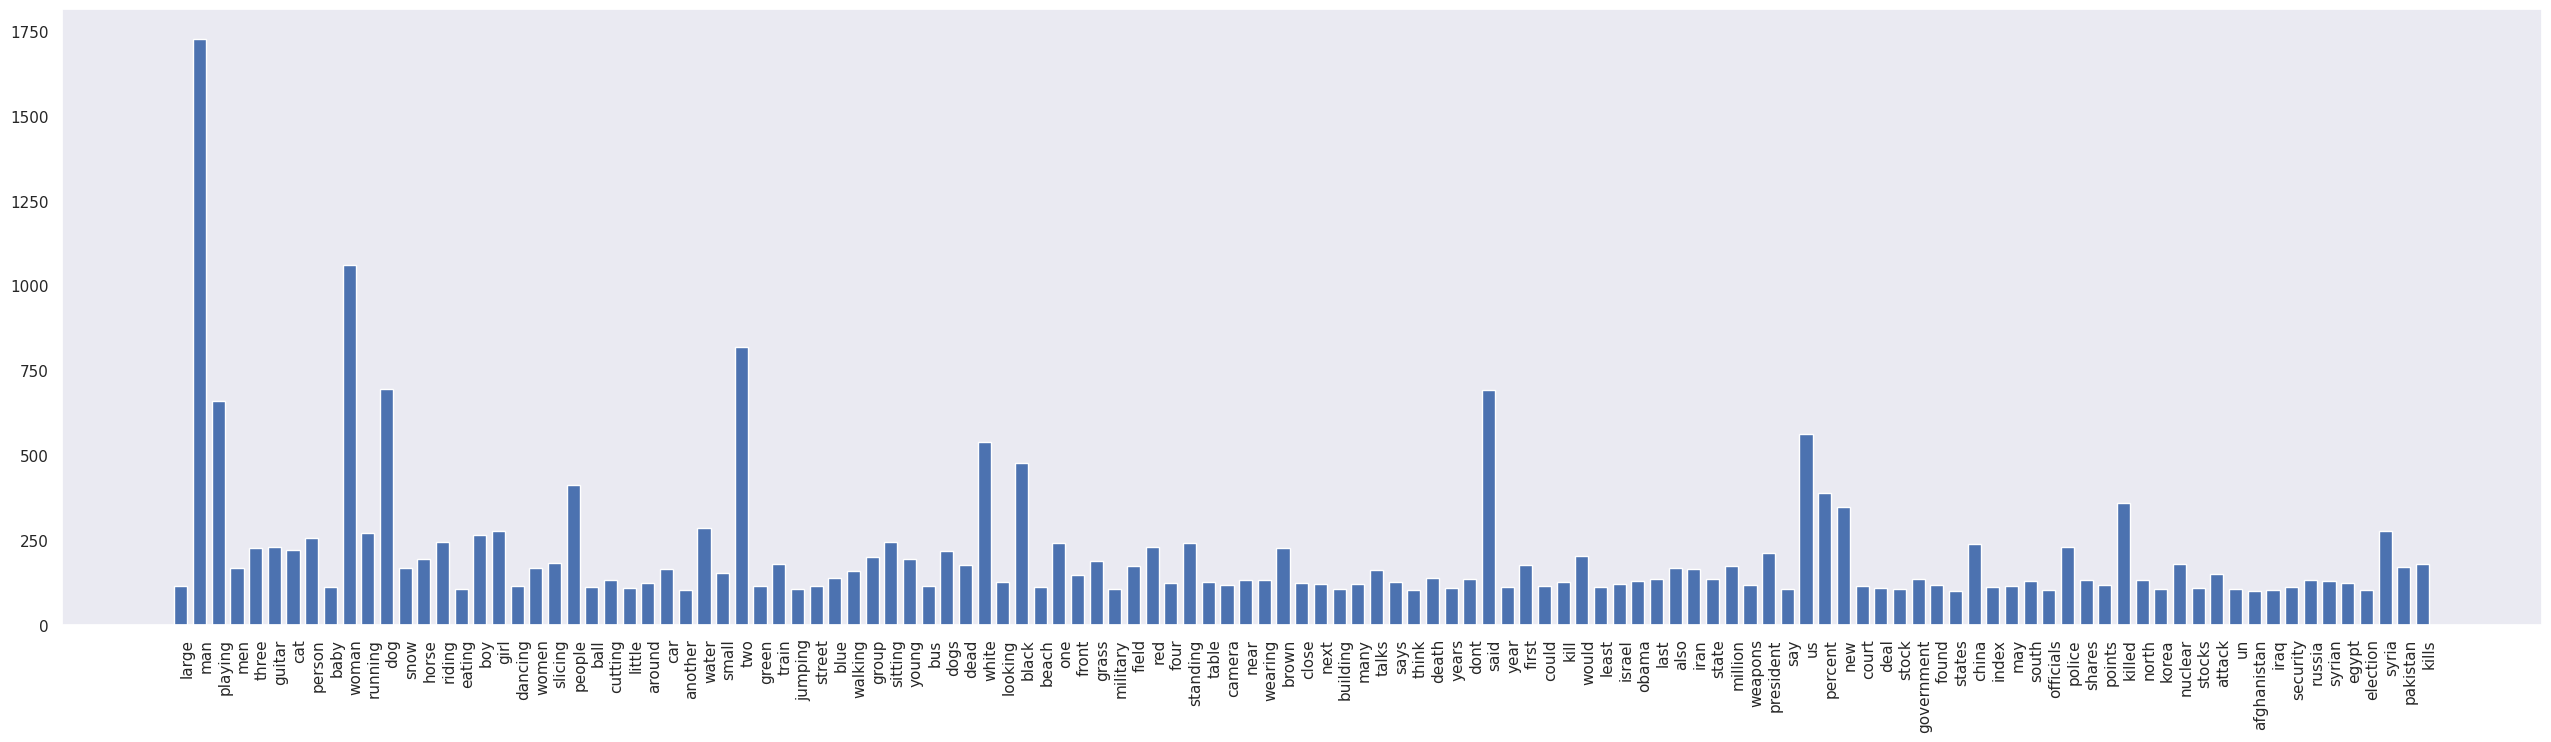

In [ ]:
width = 0.7
_, axs = plt.subplots(1, 1, figsize=(32, 8))
axs.bar(np.arange(len(counts_nostopwords_filtered)), counts_nostopwords_filtered.values(), width)
axs.set_xticks(np.arange(len(counts_nostopwords_filtered)) + width * 0.5, counts_nostopwords_filtered.keys(), rotation=90)
axs.grid(False)

## 1.6 Word embeddings investigation

Word embeddings allow to obtain a very dense and compact representation of words, based on the context within which they appear in the sentences. We can learn word embeddings directly from our dataset using algorithms like Word2Vec. However, we need to have a large dataset to obtain high quality embeddings.

Instead, we will download pre-trained embeddings that have been learnt on very large corpora. In particular, we can use the `gensim` library to download and use embeddings computed on the Google News dataset using the Word2Vec algorithm.

In [ ]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300')

[=================================================-] 99.9% 1660.8/1662.8MB downloaded


In [ ]:
print(f"Vocabulary size of the model: {len(model)}")
print(f"Number of dimensions of the embeddings: {model.vector_size}")

Vocabulary size of the model: 3000000
Number of dimensions of the embeddings: 300


Now we select the embeddings for the words in our dataset.

In [ ]:
s1 = df['sentence1'].tolist()
s2 = df['sentence2'].tolist()
sentences = s1 + s2

We define a function that properly tokenizes the words in our dataset.
Then, we are using `gensim` to retrieve the embedding corresponding to each word.
Finally, we are computing the embedding of a sentence by averaging together the embeddings of the words that compose the sentence.

In [ ]:
def sentence_to_embedding(sentence: str) -> np.ndarray:
    tokenized_sentences: list[str] = re.sub('\W', ' ', sentence).lower().split()
    tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]
    embedding = np.zeros(model.vector_size)
    for word in tokenized_sentences:
        if word in model:
            embedding += model[word]
    return embedding / len(sentence)

In [ ]:
sentence_embeddings = np.array(list(map(sentence_to_embedding, sentences)))
sentence_embeddings.shape

(17256, 300)

We can visualize the embedding space in order to study its properties. However, given that the embeddings we are using have 300 dimensions, we first need to apply t-SNE, a dimensionality reduction technique that allows us to obtain a 3-dimensional representation of our data, so that we can plot it.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=1000, n_jobs=-1, verbose=2)
tsne_embedding = tsne.fit_transform(sentence_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17256 samples in 0.004s...
[t-SNE] Computed neighbors for 17256 samples in 7.725s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17256
[t-SNE] Computed conditional probabilities for sample 2000 / 17256
[t-SNE] Computed conditional probabilities for sample 3000 / 17256
[t-SNE] Computed conditional probabilities for sample 4000 / 17256
[t-SNE] Computed conditional probabilities for sample 5000 / 17256
[t-SNE] Computed conditional probabilities for sample 6000 / 17256
[t-SNE] Computed conditional probabilities for sample 7000 / 17256
[t-SNE] Computed conditional probabilities for sample 8000 / 17256
[t-SNE] Computed conditional probabilities for sample 9000 / 17256
[t-SNE] Computed conditional probabilities for sample 10000 / 17256
[t-SNE] Computed conditional probabilities for sample 11000 / 17256
[t-SNE] Computed conditional probabilities for sample 12000 / 17256
[t-SNE] Computed conditional probabilities for sam

In [ ]:
x, y, z = np.transpose(tsne_embedding)
x1, y1, z1 = np.transpose(tsne_embedding[:len(df)])
x2, y2, z2 = np.transpose(tsne_embedding[len(df):])

Visualize the embeddings of a limited number of sentences, selected randomly.

In [ ]:
n_pairs = 200
ids = np.random.randint(0, len(df), n_pairs)

In [ ]:
fig1 = px.scatter_3d(x=x1[ids], y=y1[ids], z=z1[ids])
fig2 = px.scatter_3d(x=x2[ids], y=y2[ids], z=z2[ids])
fig1.update_traces(marker={'size': 7, 'color': 'red'})
fig1.add_trace(fig2.data[0])

As expected, the embeddings have filed up the whole space, while keeping their centre in the origin. We can see in red the embeddings associated to the first sentence of the pairs, and in the blue of the second sentence.

To study the property of the embedding space, we select some similar and some non-similar sentences and visualize them.

In [ ]:
similarity = [5, 4, 3, 2, 1, 0]
ids = [0, 29, 23, 71, 45, 141]
fig1 = px.scatter_3d(x=x1[ids], y=y1[ids], z=z1[ids], text=similarity)
fig2 = px.scatter_3d(x=x2[ids], y=y2[ids], z=z2[ids], text=similarity)
fig1.update_traces(marker={'size': 7, 'color': 'red'})
fig1.add_trace(fig2.data[0])

We can see that as expected, the two embeddings associated with the sentences with similarity 4 and 5 are basically overlapping, whereas the other ones are more spread out in the space.

## 1.7 Document clustering

Clustering is an unsupervised ML technique that can be used to study the data and to extract patterns from it.

Clustering techniques work with a vectorized representation of the documents/sentences: we will use the word embeddings computed in the previous section.

In [ ]:
from sklearn.cluster import KMeans

We will use k-Means, which is one of the most popular clustering algorithms, since it is quite fast but also scalable and robust.

### 1.7.1 Cluster by genre

Recall that the text we are working with comes from 3 different sources, specified by the `genre` column in the dataset. 

We investigate whether there is a correlation between the content of the sentences and the source their source.

In [ ]:
k = 3
kmeans = KMeans(n_clusters=k, max_iter=500, n_init=5)
kmeans.fit(sentence_embeddings)
fig = px.scatter_3d(x=x, y=y, z=z, color=kmeans.labels_.astype(str))
fig.update_traces(marker={'size': 7, 'line': {'width': 2}})

In [ ]:
genres = df['genre'].tolist() + df['genre'].tolist()
fig = px.scatter_3d(x=x, y=y, z=z, color=genres)
fig.update_traces(marker={'size': 7, 'line': {'width': 2}})

The first plot uses as colors the clusters found by k-Means, the second one the `genre` feature of the dataset. We can see that there is a very strong correlation. This is interesting because it suggests that we could train a classifier to predict the source of the pair of sentences on the basis of the content of the sentences.

And that's exactly what we will do later.

### 1.7.2 Cluster by file

We investigate whether the same correlation holds between the `file` feature and the content of the sentences.

In [ ]:
df['file'].nunique()

9

In [ ]:
k = 9
kmeans = KMeans(n_clusters=k, max_iter=500, n_init=5, random_state=0)
kmeans.fit(sentence_embeddings)
color_seq = ['#EF553B', '#636EFA', '#B6E880','#AB63FA','#FFA15A','#FF97FF','#00CC96','#FF6692',
'#19D3F3','#FECB52']
fig = px.scatter_3d(x=x, y=y, z=z, color=kmeans.labels_.astype(str), color_discrete_sequence=color_seq)
fig.update_traces(marker={'size': 7, 'line': {'width': 2}})

In [ ]:
files = df['file'].tolist() + df['file'].tolist()
fig = px.scatter_3d(x=x, y=y, z=z, color=files)
fig.update_traces(marker={'size': 7, 'line': {'width': 2}})

In this case, we can see that the two results are partially overlapping but there is much less correlation than before.

### 1.7.3 Cluster by year

Lastly, we investigate whether there is a similar correlation with the `year` feature.

In [ ]:
k = 6
kmeans = KMeans(n_clusters=k, max_iter=500, n_init=5)
kmeans.fit(sentence_embeddings)
fig = px.scatter_3d(x=x, y=y, z=z, color=kmeans.labels_.astype(str))
fig.update_traces(marker={'size': 7, 'line': {'width': 2}})

In [ ]:
years = df['year'].tolist() + df['year'].tolist()
fig = px.scatter_3d(x=x, y=y, z=z, color=years)
fig.update_traces(marker={'size': 7, 'line': {'width': 2}})

This time, we can see that the clusters found have nothing to do with the year. 
This is expected since, as we can see from the second plot, there seem to be no correlation between the year and the content of the sentences.

## 1.8 Topic Modelling

Topic Modelling is another technique that is interesting to apply to our dataset of sentences. It is an unsupervised ML technique to discover topics in a collection of documents, and classify any of these documents in terms of its pertinence to each of the discovered topics.

To do so we use Latent Dirichlet Allocation (LDA), a topic model that is used for discovering abstract topics from a collection of documents.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from matplotlib import pyplot as plt

For this task we will consider all the sentences in our dataset, thus we aggregate all sentences from columns `sentence1` and `sentence2`.

Then with scikit-learn method `train_test_split` we split data randomly into a train set and a test set.

In [ ]:
tp_sentences = pd.concat([df['sentence1'], df['sentence2']]).reset_index(drop=True)
tp_labels = pd.concat([df['genre'], df['genre']]).reset_index(drop=True)

tp_sentences_train, tp_sentences_test, tp_label_train, tp_label_test = train_test_split(tp_sentences, tp_labels, test_size=0.4)
print('Number of training sentences:', len(tp_sentences_train))
print('Number of testing sentences:', len(tp_sentences_test))

Number of training sentences: 10353
Number of testing sentences: 6903


First we build the CountVectorizer, since LDA works with counts, setting it to remove english stopwords, and to consider only terms that occur at least 5 times and at most in half of the sentences.

Then we can use `fit_transform` to learn the vocabulary dictionary and return the document-term matrix.

In [ ]:
tp_vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
tp_vector_sentences_train = tp_vectorizer.fit_transform(tp_sentences_train)

We use `get_feature_names_out` to extract the names of the features generated by the transformation. We notice that this vocabulary is smaller than what computed previously.

In [ ]:
tp_vocab = tp_vectorizer.get_feature_names_out()
len(tp_vocab)

2633

Now we can fit the LDA model, setting the number of topics to learn to 30, since our dataset is not that large, and we'll perform 50 iterations.

In [ ]:
lda = LatentDirichletAllocation(n_components=30, verbose=1, learning_method='online', max_iter=50, n_jobs=-1)
lda.fit(tp_vector_sentences_train)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

LatentDirichletAllocation(learning_method='online', max_iter=50,
                          n_components=30, n_jobs=-1, verbose=1)

Once we've learned the model, we can compute the perplexity, a measure of its performance, that tells how confused our model is at seeing new data:

In [ ]:
tp_vector_sentences_test = tp_vectorizer.transform(tp_sentences_test)
lda.perplexity(tp_vector_sentences_test)

3309.428903198483

We can see which are the words (the 10 most important) for each of the discovered topics:

In [ ]:
for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(tp_vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

Topic 1:	 [year, weapons, monday, percent, friday, 20, billion, trade, taking, 32]
Topic 2:	 [people, killed, group, table, russian, international, old, outside, room, afghanistan]
Topic 3:	 [eating, cents, vote, second, yes, quarter, share, tree, make, home]
Topic 4:	 [south, north, election, beach, korea, like, israel, open, air, presidential]
Topic 5:	 [woman, girl, wearing, little, holding, shirt, stands, singing, face, june]
Topic 6:	 [sitting, cat, years, bird, long, head, laying, floor, prison, wins]
Topic 7:	 [man, riding, blue, deal, potato, peeling, stick, boat, mouth, fish]
Topic 8:	 [world, think, 000, news, yesterday, boys, called, point, thing, largest]
Topic 9:	 [boy, government, russia, officials, forces, arms, board, national, war, big]
Topic 10:	 [iraq, drone, east, taliban, 17, shot, dirt, game, held, april]
Topic 11:	 [said, china, red, obama, military, bus, street, time, end, opposition]
Topic 12:	 [white, black, running, dog, state, field, building, city, palestin

We can also plot the composition of the topics with a bar chart, that shows the level of contribution of a word to a topic.

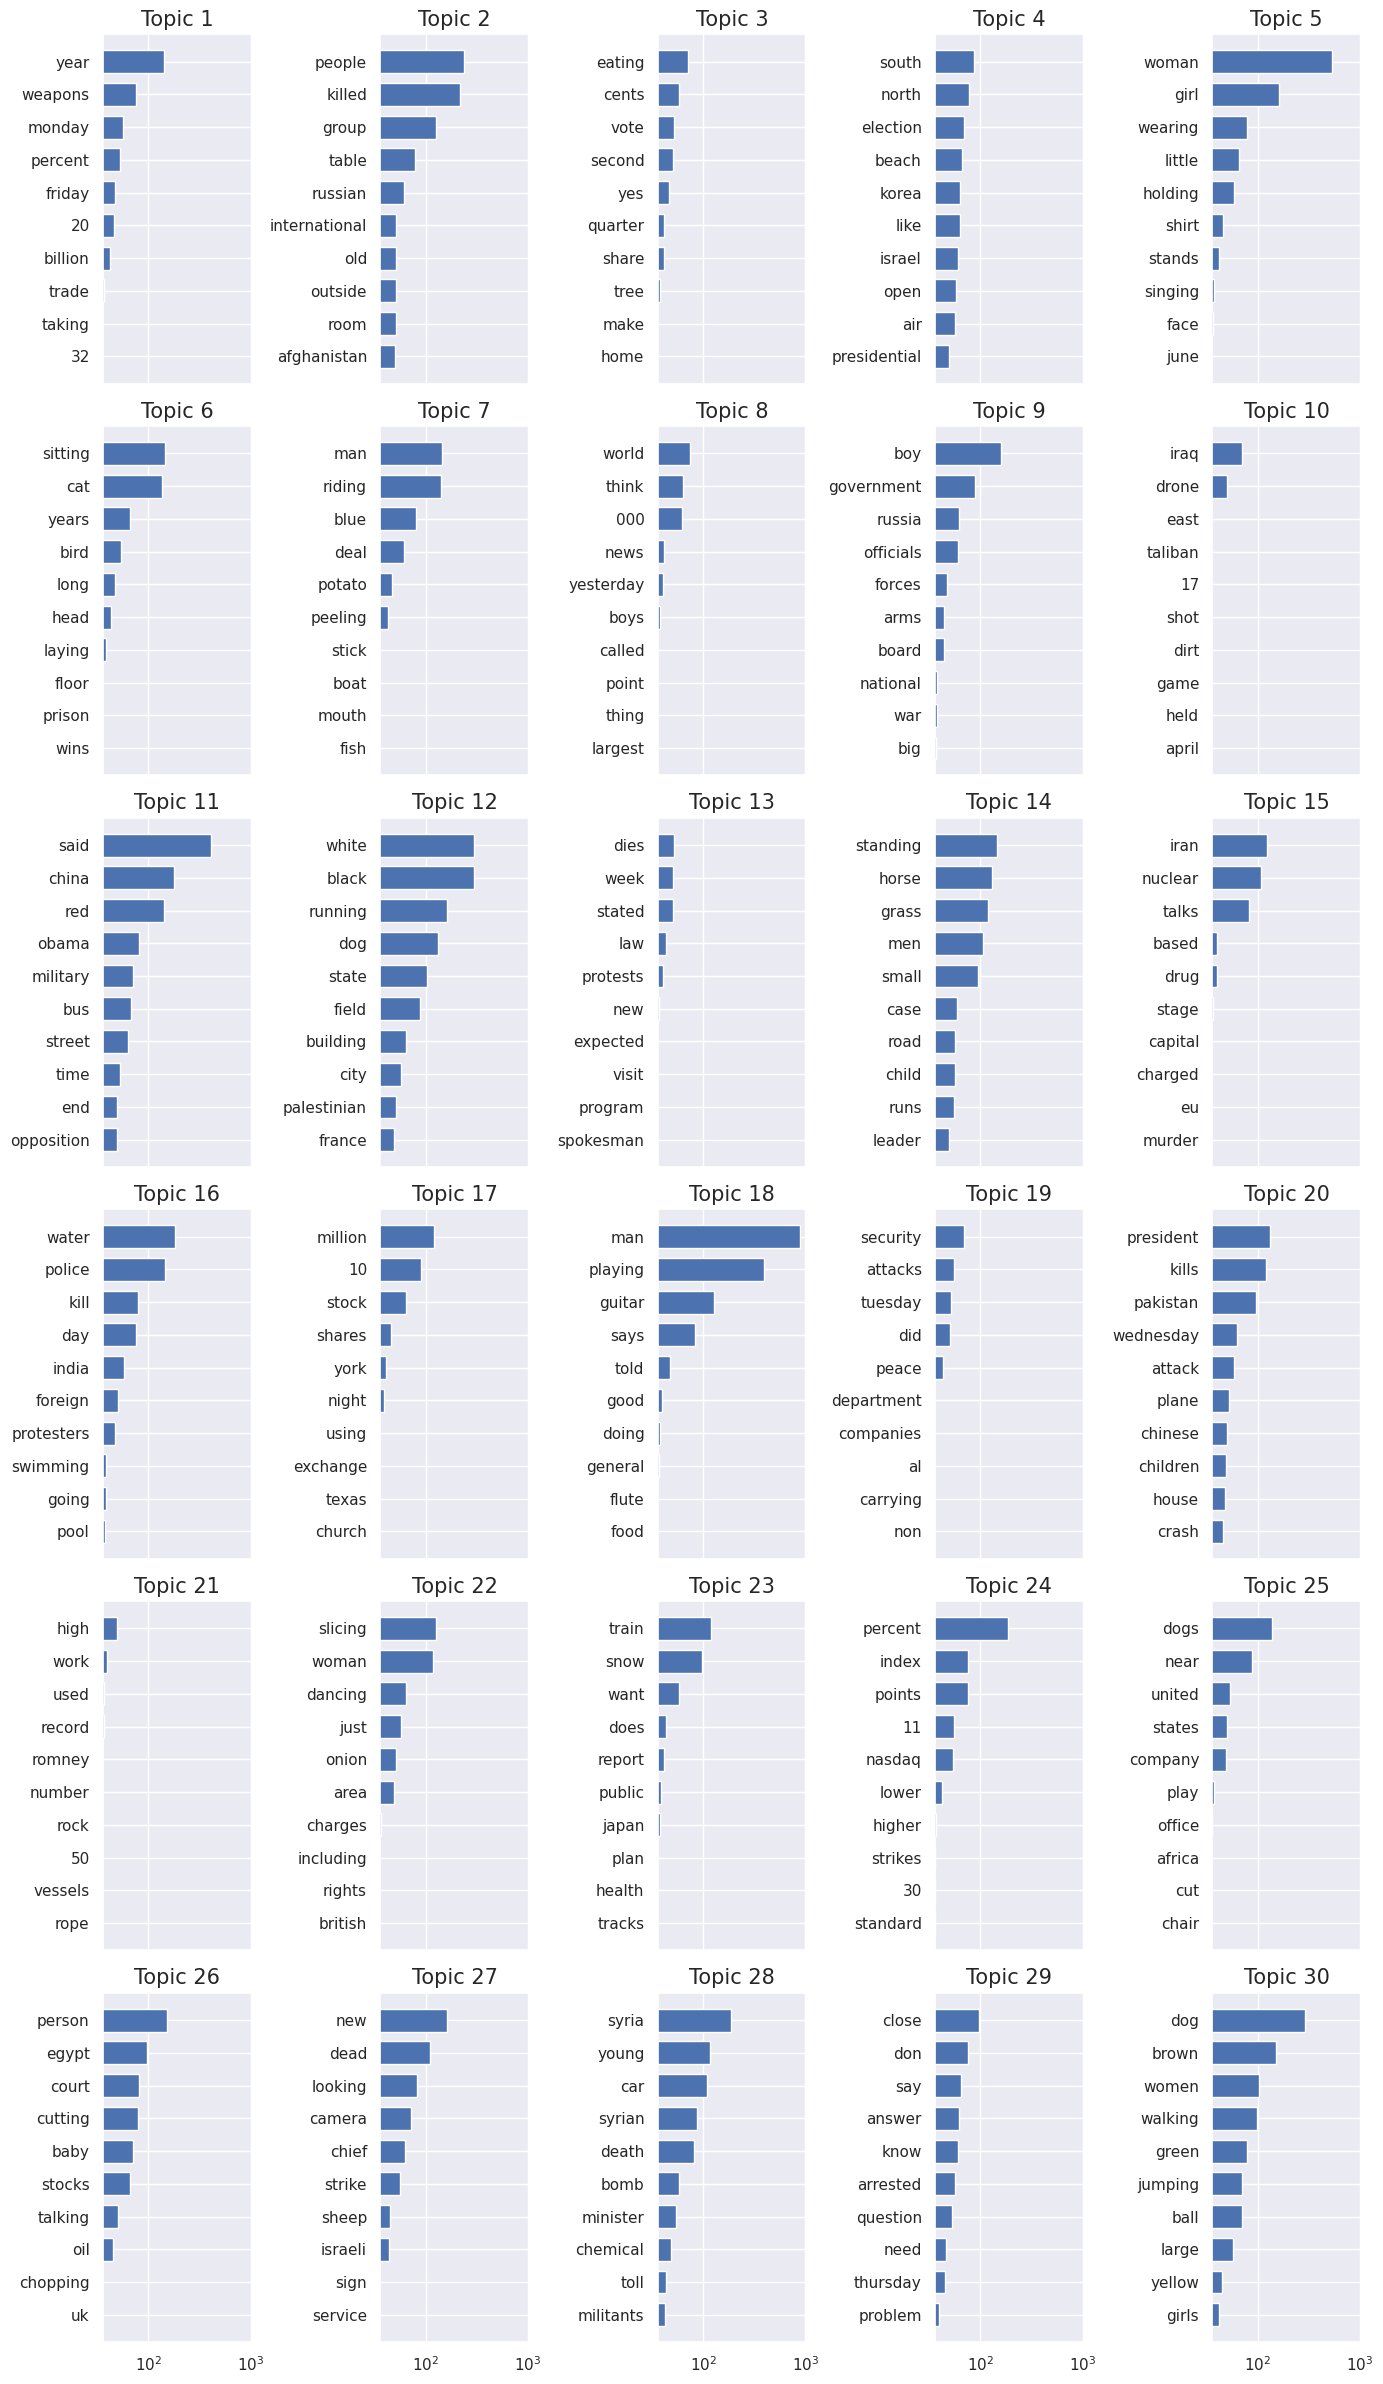

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex='all')
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [tp_vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

Looking at these discovered topics we can see that there is good coherence, except some words here and there in the topics that seem a bit off. Indeed, we expected the quality of topics not to be perfect given that our dataset is quite limited, but the results are still good.

Now we visualize the topic representation of the sentences in the test set. To do so we use t-SNE to reduce the high dimensional data to a 3-dimensional data representation:

In [ ]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(n_components=3).fit_transform(lda.transform(tp_vector_sentences_test))
tsne_embedding.shape

(6903, 3)

We convert the t-SNE embedding to the three coordinates x, y and z:

In [ ]:
[x, y, z] = np.transpose(tsne_embedding)

Finally, we can see a plot of our test sentences based on the topics we've learned in this section with LDA:

In [ ]:
freq_topic = [topic_vec.argsort()[-1] for topic_vec in lda.transform(tp_vector_sentences_test)]

fig = px.scatter_3d(x=x, y=y, z=z, color=freq_topic)
fig.update_traces(marker={'size': 3,'line': {'width': 2}})

We see that sentences with the same topic are essentially grouped together in the space.

#  2. Models

Now that we have a proper understanding of the data at our disposal, we can focus on our original task of computing the similarity between a pair of sentences. We decided to model this task as a regression problem, since in our dataset the score is a continuous variable.

Therefore, all of our models will receive as input the content of the two sentences and will predict a similarity score in the range $[0,1]$.

Note that we can easily use the output of the regression problem to perform classification. For instance, we can infer that all the sentences with a similarity score in the range $[0, 0.5)$ will be classified as not similar, and the ones in the range $[0.5, 1]$ as similar.

We evaluate the quality of our models using the following metrics:
- Mean Absolute Error (MAE)
- Root Mean Square Error (RMSE)
- R2 Score

Evaluations are performed by comparing the scores predicted by the models with the ones contained in the *test* split of the original dataset.

The following data structure is used to keep track of the values of the metrics for every possible model we are going to use, so that we can plot and compare them later.

In [ ]:
metrics_results = {
    'mae': list(),
    'rmse': list(),
    'r2': list()
}

The following function computes the metrics, prints them and stores them into the data structure.

In [ ]:
def evaluate(scores: np.ndarray, model_name: str , model_type: str) -> None:
    # Compute the metrics
    actual_scores = df_test['score'].to_numpy()
    mae = mean_absolute_error(actual_scores, scores)
    rmse = mean_squared_error(actual_scores, scores, squared=False)
    r2 = r2_score(actual_scores, scores)

    # Print the results
    print(f"MAE: {mae:.5f}")
    print(f"RMSE: {rmse:.5f}")
    print(f"R2: {r2:.5f}")

    # Store the results in a dictionary
    metrics_results['mae'].append((model_name, model_type, mae))
    metrics_results['rmse'].append((model_name, model_type, rmse))
    if r2 >= 0: metrics_results['r2'].append((model_name, model_type, r2))

Sentence similarity is a task that can be solved either with an unsupervised or with a supervised approach.

In the unsupervised approach, we vectorize our sentences using different algorithms, and then we compute the cosine similarity between them to get the score we need.

In the supervised approach, the vectorized sentences and the scores in the dataset are used to train different regression models, in order to achieve (we expect) even better results.

## 2.1 TF-IDF

TF-IDF is a widely used technique in natural language processing. This statistical measure evaluates the importance of a term within a document or a corpus of documents; in fact, it takes into account both the frequency of a term in a specific document (TF) and its rarity in the entire corpus (IDF), aiming to identify the most relevant and distinctive words in sentences.

So, our aim now is to represent every sentence as a TF-IDF vector and try to compute the **cosine similarity** between each pair of sentences.

Before vectorising our corpus, let's transform all the sentences into lower case and remove the punctuation to be sure to avoid an incorrect count of similar terms that would appear as different because of stylistic reasons or typos.

In [ ]:
def process_tfidf(df: pd.DataFrame) -> pd.DataFrame:
    df['sentence1'] = df['sentence1'].apply(lambda x : x.lower())
    df['sentence2'] = df['sentence2'].apply(lambda x : x.lower())
    for i in range(0,len(df)):
      df['sentence1'][i] = re.sub(regex, '', df['sentence1'][i])
      df['sentence2'][i] = re.sub(regex, '', df['sentence2'][i])
    return df

It is useful to make a copy of our original datasets to preserve them for future analysis. Then we can apply the previous explained processing:

In [ ]:
# new dataframes
df_tfidf = df.copy()
df_tfidf_train2 = df_train.copy()
df_tfidf_dev = df_dev.copy()
df_tfidf_test = df_test.copy()
df_tfidf_train = pd.concat([df_tfidf_train2, df_tfidf_dev]).reset_index(drop=True)
df_tfidf_train['score'] = scaler.fit_transform(df_tfidf_train[['score']])
df_tfidf_test['score'] = scaler.fit_transform(df_tfidf_test[['score']])

df_tfidf_train = process_tfidf(df_tfidf_train)
df_tfidf_test = process_tfidf(df_tfidf_test)
df_tfidf = process_tfidf(df_tfidf)

We can decide to merge also the "train" and "dev" datasets so that we could have more training data.

We start the creation of the collection of documents by converting the pandas' dataframes into Python dictionaries.

In [ ]:
dict_df = df_tfidf.to_dict('records')

In [ ]:
dict_train = df_tfidf_train.to_dict('records')
dict_train[0]

{'genre': 'captions',
 'file': 'MSRvid',
 'year': '2012',
 'index': 1,
 'score': 1.0,
 'sentence1': 'a plane is taking off',
 'sentence2': 'an air plane is taking off'}

In [ ]:
dict_test = df_tfidf_test.to_dict('records')
dict_test[0]

{'genre': 'captions',
 'file': 'MSRvid',
 'year': '2012',
 'index': 24,
 'score': 0.5,
 'sentence1': 'a girl is styling her hair',
 'sentence2': 'a girl is brushing her hair'}

Now we are going to create our corpus combining the pair of sentences we need to vectorize. In a first place we create our collection using the entire dataset because the vectorizer need to consider the whole vocabulary, but then the vectorizer will be applied only to the test dataset to make the results comparable with the other methods.

In [ ]:
document = [f"{sample['sentence1']} \n\n {sample['sentence2']}" for sample in dict_df]
document[0]

'a plane is taking off \n\n an air plane is taking off'

Then we have to create different collections to separate the pairs of sentences and apply individually the vectorizer. So we create:
 

*   "document_test1"  containing all the first sentences of each pair in the test dataset.
*   "document_test2"  containing all the second sentences of each pair in the test dataset.




In [ ]:
document_test1 = [f"{sample['sentence1']}" for sample in dict_test]
document_test2 = [f"{sample['sentence2']}" for sample in dict_test]

We also need to retain the associated labels (normalized similarity scores) that can be useful for the assessment of the cosine similarity results even in the unsupervised task.

In [ ]:
scores_test = [sample['score'] for sample in dict_test]

### 2.1.1 Unsupervised

Now we can create the vectorizer using the corpus containing all the sentences of the whole dataset. We will use the `TfidfVectorizer` from Scikit-Learn to do this.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer= 'word', max_df=0.8, min_df=4, stop_words="english")
vectorizer.fit(document)

TfidfVectorizer(max_df=0.8, min_df=4, stop_words='english')

With this function, we can modify the arguments to control the resulting vocabulary. We have set the previous parameters' values, after different attempts, because they assured us the best results in the next tasks.

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 3806


At this point we can convert the separated sentences into a vector format.

In [ ]:
vector_document1 = vectorizer.transform(document_test1)
sorted([(vocab[j], vector_document1[1, j]) for j in vector_document1[1].nonzero()[1]], key=lambda x: -x[1])

[('soccer', 0.5130635521494372),
 ('play', 0.4637895505720887),
 ('beach', 0.44099709655242814),
 ('men', 0.4059384211452135),
 ('group', 0.4029895821313515)]

In [ ]:
vector_document2 = vectorizer.transform(document_test2)
sorted([(vocab[j], vector_document2[1, j]) for j in vector_document2[1].nonzero()[1]], key=lambda x: -x[1])

[('soccer', 0.5223647648773634),
 ('boys', 0.5090753700689273),
 ('beach', 0.4489918328579944),
 ('group', 0.4102952888315032),
 ('playing', 0.3131156814873597)]

The vectorizer also normalizes the resulting sentence representations such that their vectors have length one. In this way, the dot-product between these vectors can compute the cosine of the angle between them, which is a value in the range [0,1] corresponding to the cosine similarity.

So, we are going to compute the dot-product between each vectorized sentence of the first collection (document_test1) and the vectorized sentence in the second collection (document_test2) corresponding to the sentences originally paired in the dataset. 

In [ ]:
vec = pd.DataFrame(columns=['Similarity','Normalized Score'])

for i in range(0,len(df_tfidf_test)):
  new_row = {'Similarity': vector_document1[i].multiply(vector_document2[i]).sum(), 'Normalized Score': scores_test[i]}
  vec.loc[len(vec)] = new_row

vec.head(10)

Similarity  Normalized Score
0    0.720419            0.5000
1    0.631355            0.7200
2    0.732837            1.0000
3    0.716829            0.8400
4    0.316837            0.3000
5    0.424173            0.3600
6    0.750115            0.7000
7    0.398504            0.4400
8    0.631888            0.4400
9    0.395953            0.3428

So, after computing the cosine similarity of each pair of sentences we can compare them with the normalized scores in the original test set.

In [ ]:
evaluate(vec['Similarity'],"TF-IDF", "Unsupervised")

MAE: 0.19500
RMSE: 0.26703
R2: 0.23344


These metrics are not quite bad, but we can try to improve the results by including also bi-grams and tri-grams into our vocabulary.

Let's create a vectorizer which include unigrams and **bi-grams** and next try to perform again the same steps as before.

In [ ]:
vectorizer_bi = TfidfVectorizer(analyzer= 'word', max_df=0.8, min_df=4, ngram_range=(1,2), stop_words='english')
vectorizer_bi.fit(document)

TfidfVectorizer(max_df=0.8, min_df=4, ngram_range=(1, 2), stop_words='english')

In [ ]:
vocab_bi = vectorizer_bi.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab_bi)}")

Length of vocabulary: 5351


In [ ]:
vector_document1_bi = vectorizer_bi.transform(document_test1)
vector_document2_bi = vectorizer_bi.transform(document_test2)

In [ ]:
vec_bi = pd.DataFrame(columns=['Similarity','Normalized Score'])

for i in range(0,len(df_tfidf_test)):
  new_row = {'Similarity': vector_document1_bi[i].multiply(vector_document2_bi[i]).sum(), 'Normalized Score': scores_test[i]}
  vec_bi.loc[len(vec_bi)] = new_row

vec_bi.head(10)

Similarity  Normalized Score
0    0.720419            0.5000
1    0.399319            0.7200
2    0.732837            1.0000
3    0.418489            0.8400
4    0.299187            0.3000
5    0.471268            0.3600
6    0.655622            0.7000
7    0.385536            0.4400
8    0.640875            0.4400
9    0.379931            0.3428

Finally, let's create a vectorizer which include unigrams, bi-grams and **tri-grams** and follow again the same steps.

In [ ]:
vectorizer_tri = TfidfVectorizer(analyzer= 'word', max_df=0.8, min_df=4, ngram_range=(1,3), stop_words='english')
vectorizer_tri.fit(document)

TfidfVectorizer(max_df=0.8, min_df=4, ngram_range=(1, 3), stop_words='english')

In [ ]:
vocab_tri = vectorizer_tri.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab_tri)}")

Length of vocabulary: 5869


In [ ]:
vector_document1_tri = vectorizer_tri.transform(document_test1)
vector_document2_tri = vectorizer_tri.transform(document_test2)

In [ ]:
vec_tri = pd.DataFrame(columns=['Similarity','Normalized Score'])

for i in range(0,len(df_tfidf_test)):
  new_row = {'Similarity': vector_document1_tri[i].multiply(vector_document2_tri[i]).sum(), 'Normalized Score': scores_test[i]}
  vec_tri.loc[len(vec_tri)] = new_row

vec_tri.head(10)

Similarity  Normalized Score
0    0.720419            0.5000
1    0.399319            0.7200
2    0.732837            1.0000
3    0.359854            0.8400
4    0.213224            0.3000
5    0.406319            0.3600
6    0.554964            0.7000
7    0.289749            0.4400
8    0.564746            0.4400
9    0.284660            0.3428

We can see that actually the performance tend to decrease when we try to include bi-grams, and even more by including tri-grams.

In [ ]:
print("MAE: ", mean_absolute_error(vec_bi['Normalized Score'], vec_bi['Similarity']))
print("RMSE: ", mean_squared_error(vec_bi['Normalized Score'], vec_bi['Similarity'],squared=False))
print("R2: ", r2_score(vec_bi['Normalized Score'], vec_bi['Similarity']))

MAE:  0.2078496836905177
RMSE:  0.2835973385227021
R2:  0.1353804486282536


In [ ]:
print("MAE: ", mean_absolute_error(vec_tri['Normalized Score'], vec_tri['Similarity']))
print("RMSE: ", mean_squared_error(vec_tri['Normalized Score'], vec_tri['Similarity'],squared=False))
print("R2: ", r2_score(vec_tri['Normalized Score'], vec_tri['Similarity']))

MAE:  0.21223178313451196
RMSE:  0.288163597640822
R2:  0.10731346231340799


A possible explanation of this phenomenon is that we are in presence of really short sentences (average of 10 words per sentence, but most of them are actually 5/6 words), so including bi-grams and tri-grams can actually capture a higher morphological similarity which not correspond to a semantic one.

### 2.1.2 Supervised

Exploiting the TF-IDF vector representation we can try to train some simple models to make prediction about the similarity of our sentences.

This time we convert directly the pair of sentences using the same vectorizer we have used before (the one including only unigrams), keeping separated the training sentences and the test sentences, with the relative scores (which are our labels).

In [ ]:
document_train = [f"{sample['sentence1']} \n\n {sample['sentence2']}" for sample in dict_train]
X_train = vectorizer.transform(document_train)

document_test = [f"{sample['sentence1']} \n\n {sample['sentence2']}" for sample in dict_test]
X_test = vectorizer.transform(document_test)

In [ ]:
scores_train = [sample['score'] for sample in dict_train]
# scores_test already exist from the previous task

Now we can try to train a simple **Linear Regression** model.

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train,scores_train)

LinearRegression()

In [ ]:
print("MAE train: ", mean_absolute_error(scores_train, regressor.predict(X_train)))
print("RMSE train: ",mean_squared_error(scores_train, regressor.predict(X_train),squared=False))
print("R2 train: ", r2_score(scores_train, regressor.predict(X_train)))

evaluate(regressor.predict(X_test),"LR TF-IDF", "Supervised")

MAE train:  0.14201472482718694
RMSE train:  0.18149460998482517
R2 train:  0.6230472287369648
MAE: 0.32705
RMSE: 0.43773
R2: -1.05986


Evaluating the metrics we can determine that this model does not perform well in predicting the similarity scores, and actually is characterized by a lot of overfitting, which tell us that the model is not understanding the actual behaviour of our data.

So, we can try to train also a **Support Vector Regression** model, which we expect it to understand more complex behaviours.

In [ ]:
from sklearn.svm import SVR

We use a grid search to find the best values for our hyper-parameters.

In [ ]:
# regressor = SVR()
# parameters = {'C': [10],
#              'epsilon': [0.01,0.1],
#              'gamma':['auto'],
#              'kernel': ['linear', 'poly','rbf'],
#              'degree': [2,3,5]
#              }

# from sklearn.model_selection import GridSearchCV
# gs = GridSearchCV(regressor, parameters, cv=3, verbose = 0)

# gs = gs.fit(X_train,scores_train)

In [ ]:
# print('***GRIDSEARCH RESULTS***')
# print("Best score: %f using %s" % (gs.best_score_, gs.best_params_))
# means = gs.cv_results_['mean_test_score']
# stds = gs.cv_results_['std_test_score']
# params = gs.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
model = SVR(C= 10, degree= 2, epsilon= 0.1, gamma= 'auto', kernel= 'rbf')
model.fit(X_train,scores_train)

SVR(C=10, degree=2, gamma='auto')

In [ ]:
print("MAE train: ", mean_absolute_error(scores_train, model.predict(X_train)))
print("RMSE train: ", mean_squared_error(scores_train, model.predict(X_train),squared=False))
print("R2 train: ", r2_score(scores_train, model.predict(X_train)))

evaluate(model.predict(X_test),"SVR TF-IDF", "Supervised")

MAE train:  0.2377423030861575
RMSE train:  0.2834854205409429
R2 train:  0.0803534767283004
MAE: 0.24959
RMSE: 0.29585
R2: 0.05905


We can see that even if the model is understanding the behavior of our data due to the absence of overfitting, it cannot predict well the similarity scores. So we can assess that probably the TF-IDF vector is not the best way to represent our sentences in this kind of task.

In fact, by computing the cosine similarity with TF-IDF we tend to attribute a higher score to the sentences which present identical terms; however, sentences with identical terms can somehow be very different in a semantic point of view, while sentences with not similar terms can actually share the same meaning.

### 2.1.3 POS Tagging

We can try to attribute to each word of our sentences its POS tag, trying to understand better some differences: in fact, the same term can be used for different purposes in different sentences, changing their actual meaning.

Now we remove the stopwords before create the vectorizer because `TfidfVectorizer` will not recognize stopwords after applying POS tagging.

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
for i in range(0,len(df_tfidf)):
  words1 = df_tfidf['sentence1'][i].lower().split()
  words2 = df_tfidf['sentence2'][i].lower().split()
  df_tfidf['sentence1'][i] = ' '.join([w for w in words1 if w not in stopwords.words('english')])
  df_tfidf['sentence2'][i] = ' '.join([w for w in words2 if w not in stopwords.words('english')])

for i in range(0,len(df_tfidf_test)):
  words1 = df_tfidf_test['sentence1'][i].lower().split()
  words2 = df_tfidf_test['sentence2'][i].lower().split()
  df_tfidf_test['sentence1'][i] = ' '.join([w for w in words1 if w not in stopwords.words('english')])
  df_tfidf_test['sentence2'][i] = ' '.join([w for w in words2 if w not in stopwords.words('english')])

Then we recreate our collections of documents:

In [ ]:
dict_df = df_tfidf.to_dict('records')
document = [f"{sample['sentence1']} \n\n {sample['sentence2']}" for sample in dict_df]

dict_test = df_tfidf_test.to_dict('records')
document_test1 = [f"{sample['sentence1']}" for sample in dict_test]
document_test2 = [f"{sample['sentence2']}" for sample in dict_test]

We can use `spaCy` to perform part-of-speech (POS) tagging, and next we merge all the words with their tags to recreate the sentence's structure.

In [ ]:
import spacy
import en_core_web_sm
nlp_model = en_core_web_sm.load()

In [ ]:
doc_pos=[]
string= ""

for i in range(0,len(df_tfidf)):
  text = nlp_model(document[i])
  doc_pos.append(' '.join([f"{(w,w.pos_)}" for w in text]))

In [ ]:
doc_pos1=[]
string= ""

for i in range(0,len(df_tfidf_test)):
  text = nlp_model(document_test1[i])
  doc_pos1.append(' '.join([f"{(w,w.pos_)}" for w in text]))

In [ ]:
doc_pos2=[]
string= ""

for i in range(0,len(df_tfidf_test)):
  text = nlp_model(document_test2[i])
  doc_pos2.append(' '.join([f"{(w,w.pos_)}" for w in text]))

The new sentences will have these form:

In [ ]:
doc_pos1[0]

"(girl, 'NOUN') (styling, 'NOUN') (hair, 'NOUN')"

Through a regex we create the pattern in which we identify our tokens (the original term and its POS tag), and then create the vectorizer.

In [ ]:
pattern = r'\([A-Za-z0-9]+,\s\'[A-Z]+\'\)'
pattern

"\\([A-Za-z0-9]+,\\s\\'[A-Z]+\\'\\)"

In [ ]:
vectorizer = TfidfVectorizer(analyzer= 'word', token_pattern=pattern, max_df=0.8, min_df=4, lowercase=False)
vectorizer.fit(doc_pos)

TfidfVectorizer(lowercase=False, max_df=0.8, min_df=4,
                token_pattern="\\([A-Za-z0-9]+,\\s\\'[A-Z]+\\'\\)")

In [ ]:
vocab = vectorizer.get_feature_names_out()
print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 4195


Then we convert our sentences into TF-IDF vectors.

In [ ]:
vector_document1 = vectorizer.transform(doc_pos1)
vector_document2 = vectorizer.transform(doc_pos2)

And compute the cosine similarity for each pair of new sentences:

In [ ]:
vec = pd.DataFrame(columns=['Similarity','Normalized Score'])

for i in range(0,len(df_tfidf_test)):
  new_row = {'Similarity': vector_document1[i].multiply(vector_document2[i]).sum(), 'Normalized Score': scores_test[i]}
  vec.loc[len(vec)] = new_row

In [ ]:
print("MAE: ", mean_absolute_error(vec['Normalized Score'], vec['Similarity']))
print("RMSE: ", np.sqrt(mean_squared_error(vec['Normalized Score'], vec['Similarity'])))
print("R2: ", r2_score(vec['Normalized Score'], vec['Similarity']))

MAE:  0.21053698234026855
RMSE:  0.28227575521059584
R2:  0.14342004676454212


Unfortunately, we can see that the results are not actually improved compared to the version without POS tag.

## 2.2 GloVe Embeddings

### 2.2.1 Unsupervised

We now use the GloVe embeddings in an unsupervised way with the Cosine Similarity. 

In [ ]:
#Loading the embedding model
import gensim.downloader as api
glove100 = api.load('glove-wiki-gigaword-100')

[================================================--] 97.5% 124.8/128.1MB downloaded


In [ ]:
def sentence_to_embedding100(sentence: str) -> np.ndarray:
    tokenized_sentences: list[str] = re.sub('\W', ' ', sentence).lower().split()
    tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]
    embedding = np.zeros(glove100.vector_size)
    for word in tokenized_sentences:
        if word in glove100:
            embedding += glove100[word]
    return embedding / len(sentence)

Creating the arrays of the embedded sentences

In [ ]:
s1_test = np.array(list(map(sentence_to_embedding100, df_test['sentence1'])))
s2_test = np.array(list(map(sentence_to_embedding100, df_test['sentence2'])))

Predicting similarity with the cosine similarity

In [ ]:
pred_scores_glove100 = cosine_similarity(s1_test, s2_test).diagonal()
pred_scores_glove100

array([0.95846429, 0.98489088, 0.9508961 , ..., 0.82571324, 0.82073795,
       0.85261919])

In [ ]:
evaluate(pred_scores_glove100, 'GloVe-100', 'Unsupervised')

MAE: 0.41214
RMSE: 0.49396
R2: -1.62304


Now we move on to GloVe-200 and we do the same thing

In [ ]:
#Loading the model
import gensim.downloader as api
glove200 = api.load('glove-wiki-gigaword-200')

[=================================================-] 98.8% 249.0/252.1MB downloaded


In [ ]:
def sentence_to_embedding200(sentence: str) -> np.ndarray:
    tokenized_sentences: list[str] = re.sub('\W', ' ', sentence).lower().split()
    tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]
    embedding = np.zeros(glove200.vector_size)
    for word in tokenized_sentences:
        if word in glove200:
            embedding += glove200[word]
    return embedding / len(sentence)

In [ ]:
s1_test = np.array(list(map(sentence_to_embedding200, df_test['sentence1'])))
s2_test = np.array(list(map(sentence_to_embedding200, df_test['sentence2'])))

In [ ]:
pred_scores_glove200 = cosine_similarity(s1_test, s2_test).diagonal()
pred_scores_glove200

array([0.93870805, 0.97666908, 0.93871563, ..., 0.78975367, 0.77953684,
       0.79278265])

In [ ]:
evaluate(pred_scores_glove200, 'GloVe-200', 'Unsupervised')

MAE: 0.38893
RMSE: 0.46855
R2: -1.36014


In both cases we can notice that the results are not good.

### 2.2.2 Supervised

We train Linear Regression model and SVR model on GloVe embeddings. Respectively the Linear Regression model gives the best results with 'glove-wiki-gigaword-100' whereas SVR model gives the best results with 'glove-wiki-gigaword-200'. This can be easily explained because SVR is more capable to handle a large amount of features than Linear Regression.

Given the results obtained during the course of this project, we decided to apply directly the embedding to the couple of sentences instead.

#### Linear regression with glove-wiki-gigaword-100 embeddings

In [ ]:
# concatenating the couples of sentences
corpus_train = np.array(df_train['sentence1'] + ' ' + df_train['sentence2'])
corpus_dev = np.array(df_dev['sentence1'] + ' ' + df_dev['sentence2'])
corpus_test = np.array(df_test['sentence1'] + ' ' + df_test['sentence2'])

Creating the embedding for each dataset

In [ ]:
sentence_train = np.array(list(map(sentence_to_embedding100, corpus_train)))
sentence_dev = np.array(list(map(sentence_to_embedding100, corpus_dev)))
sentence_test = np.array(list(map(sentence_to_embedding100, corpus_test)))

In [ ]:
import torch
X_train = sentence_train
X_train = torch.from_numpy(X_train)

x_dev= sentence_dev
x_dev = torch.from_numpy(x_dev)

x_test= sentence_test
x_test = torch.from_numpy(x_test)

#concatenating train and dev in order to have larger train dataset
X_train = torch.cat([X_train, x_dev],0) 

In [ ]:
y_train = pd.concat([df_train['score'],df_dev['score']]).reset_index(drop=True)

In [ ]:
from sklearn.linear_model import LinearRegression

LinearReg = LinearRegression()
LinearReg.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = LinearReg.predict(x_test)
evaluate(y_pred, 'LR GloVe-100', 'Supervised')

MAE: 0.24511
RMSE: 0.29602
R2: 0.05800


#### SVR with glove-wiki-gigaword-200 embeddings

Obtaining the embeddings from the datasets.

In [ ]:
sentence_train = np.array(list(map(sentence_to_embedding200, corpus_train)))
sentence_dev = np.array(list(map(sentence_to_embedding200, corpus_dev)))
sentence_test = np.array(list(map(sentence_to_embedding200, corpus_test)))

In [ ]:
import torch
X_train = sentence_train
X_train = torch.from_numpy(X_train)

x_dev= sentence_dev
x_dev = torch.from_numpy(x_dev)

x_test= sentence_test
x_test = torch.from_numpy(x_test)

#concatenating train and dev in order to have larger train dataset
X_train = torch.cat([X_train, x_dev],0) 

In [ ]:
y_train = pd.concat([df_train['score'],df_dev['score']]).reset_index(drop=True)

In [ ]:
from sklearn.svm import SVR
SVR = SVR(C= 10, degree= 2, epsilon= 0.1, gamma= 'auto', kernel= 'rbf')
SVR.fit(X_train, y_train)

SVR(C=10, degree=2, gamma='auto')

In [ ]:
y_pred = SVR.predict(x_test)
evaluate(y_pred, 'SVR Glove-200', 'Supervised')

MAE: 0.24135
RMSE: 0.29256
R2: 0.07986


These results are promising, but they are still far from being good.

## 2.3 Bi-encoder

The library `sentence_transformers` contains state-of-the-art models that can be trained using *supervised* or *unsupervised* approaches to encode text at sentence-level, paragraph-level or even entire document-level.

These models generate context embeddings that represent all the information in a sentence directly, without the need to compute word embeddings separately and averaging them together. This is the ideal approach for our task given that we are working at the sentence-level.

The library gives access to both bi-encoder and cross-encoder models.
First of all, we will use a multipurpose bi-encoder based on BERT:

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
bi_enc = SentenceTransformer('all-mpnet-base-v2', device='cuda')

### 2.3.1 Unsupervised

For the unsupervised part, we can use the pre-trained model directly.

We will compute the context embeddings of every pair of sentences in our test dataset.

In [ ]:
s1_test = bi_enc.encode(df_test['sentence1'], show_progress_bar=True)
s2_test = bi_enc.encode(df_test['sentence2'], show_progress_bar=True)

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Now we can compute the similarity as usual:

In [ ]:
pred_scores = cosine_similarity(s1_test, s2_test).diagonal()
pred_scores

array([0.7515025 , 0.8024217 , 0.9708812 , ..., 0.5013467 , 0.13306257,
       0.3166733 ], dtype=float32)

In [ ]:
evaluate(pred_scores, 'Bi-encoder', 'Unsupervised')

MAE: 0.13896
RMSE: 0.18049
R2: 0.64980


We can see that there was a good improvement in the performance. But we can do better.

### 2.3.2 Supervised

#### Linear regression with Sentence BERT embeddings

We create our three embeddings from the three datasets.

In [ ]:
corpus_embeddings_train = bi_enc.encode(corpus_train, convert_to_tensor=True)
corpus_embeddings_dev = bi_enc.encode(corpus_dev, convert_to_tensor=True) 
corpus_embeddings_test = bi_enc.encode(corpus_test, convert_to_tensor=True) 

As we have done before, we concatenate the train-set and the dev-set in order to have more data to train the models with.

In [ ]:
X_train=corpus_embeddings_train
x_dev=corpus_embeddings_dev
x_test=corpus_embeddings_test

X_train = torch.cat([X_train, x_dev],0)
y_train = pd.concat([df_train['score'],df_dev['score']]).reset_index(drop=True)

X_train = X_train.cpu()
x_test = x_test.cpu()

In [ ]:
from sklearn.linear_model import LinearRegression
X_train = X_train.cpu()
LinearReg_ST = LinearRegression()
LinearReg_ST.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = LinearReg_ST.predict(x_test)
evaluate(y_pred, 'LR Bi-encoder', 'Supervised')

MAE: 0.17359
RMSE: 0.22797
R2: 0.44130


#### SVR model with Sentence BERT embeddings

In [ ]:
from sklearn.svm import SVR
SVR_ST = SVR(C= 10, degree= 2, epsilon= 0.1, gamma= 'auto', kernel= 'linear')
SVR_ST.fit(X_train, y_train)

SVR(C=10, degree=2, gamma='auto', kernel='linear')

In [ ]:
y_pred = SVR_ST.predict(x_test)
evaluate(y_pred, 'SVR Bi-encoder', 'Supervised')

MAE: 0.17614
RMSE: 0.23224
R2: 0.42017


We can see how these two models improve their performance by changing the GloVe embedding model with the sentence transformer one, which gives value to semantics similarity and not only to the words' resemblance. Surprisingly Linear Regression is slightly better.

#### Fine-tuning Sentence BERT

To conclude the supervised part, we can fine-tune the model using our dataset.
We will perform the fine-tuning using both the training dataset and the validation dataset.
Then, we will evaluate the performance of the fine-tuned model on the testing dataset.

In [ ]:
from sentence_transformers import losses, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from torch.utils.data import DataLoader
from math import ceil

First of all, we need to prepare our input data such that it is in the shape accepted by the library.

In [ ]:
df_train_dev = pd.concat([df_train, df_dev]).reset_index(drop=True)

In [ ]:
train_samples = df_train_dev.apply(lambda row: InputExample(texts=[row['sentence1'], row['sentence2']], label=row['score']), axis=1).to_list()
test_samples = df_test.apply(lambda row: InputExample(texts=[row['sentence1'], row['sentence2']], label=row['score']), axis=1).to_list()
len(train_samples), len(test_samples)

(7249, 1379)

In [ ]:
# Training hyper-parameters
train_batch_size = 32
num_epochs = 5

In [ ]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
loss = losses.CosineSimilarityLoss(model=bi_enc)
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples)
warmup_steps = ceil(len(train_dataloader) * num_epochs * 0.1) # 10% of train data for warm-up

The following cell computes the fine-tuning.
Fine-tuning takes a while and also quite a good amount of GPU memory.
Note that at the end of the procedure, the fine-tuned model is stored into the device.

We can now load the fine-tuned model to evaluate it.

In [ ]:
# Train the model
bi_enc.fit(train_objectives=[(train_dataloader, loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path="all-mpnet-base-v2-fine-tuned")

In [ ]:
bi_enc_tuned = SentenceTransformer("models/all-mpnet-base-v2-fine-tuned")

In [ ]:
s1_test = bi_enc_tuned.encode(df_test['sentence1'])
s2_test = bi_enc_tuned.encode(df_test['sentence2'])

In [ ]:
pred_scores = cosine_similarity(s1_test, s2_test).diagonal()
evaluate(pred_scores, 'Bi-encoder', 'Supervised')

MAE: 0.11547
RMSE: 0.15149
R2: 0.75328


We can see that fine-tuning lead to a significant increase in the performance.

## 2.4 Cross-encoder

Cross-encoders are another type of model available in the `sentence_transformers` library. They are known to be slower than bi-encoders and not to return any embeddings, meaning that we cannot store them in a database for later use. However, their performance is usually superior.

We will use a cross-encoder also based on BERT, designed specifically to deal with the sentence similarity task.

In [ ]:
from sentence_transformers import CrossEncoder

In [ ]:
cross_enc = CrossEncoder('cross-encoder/stsb-roberta-large', device='cuda')

### 2.4.1 Unsupervised

Again, the unsupervised part consists in encoding the pair of sentences using the pre-trained model.
This time, the model outputs the similarity score directly.

In [ ]:
sentence_pairs = df_test[['sentence1', 'sentence2']].to_numpy().tolist()

In [ ]:
pred_scores = cross_enc.predict(sentence_pairs, show_progress_bar=True)
evaluate(pred_scores, 'Cross-encoder', 'Unsupervised')

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

MAE: 0.09132
RMSE: 0.12273
R2: 0.83807


As expected, cross-encoders are out-performing any other model.

### 2.4.2 Supervised

Again, we will fine-tune the model using the data at our disposal.

In [ ]:
# Training hyper-parameters
train_batch_size = 24
num_epochs = 5

In [ ]:
train_samples = df_train_dev.apply(lambda row: InputExample(texts=[row['sentence1'], row['sentence2']], label=row['score']), axis=1).to_list()
test_samples = df_test.apply(lambda row: InputExample(texts=[row['sentence1'], row['sentence2']], label=row['score']), axis=1).to_list()
len(train_samples), len(test_samples)

(7249, 1379)

In [ ]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
cross_evaluator = CECorrelationEvaluator.from_input_examples(test_samples)

In [ ]:
# Train the model
cross_enc.fit(train_dataloader=train_dataloader,
          evaluator=cross_evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path="stsb-roberta-large-fine-tuned")

In [ ]:
cross_enc_tuned = CrossEncoder("models/stsb-roberta-large-fine-tuned")

In [ ]:
pred_scores = cross_enc_tuned.predict(sentence_pairs, show_progress_bar=True)
evaluate(pred_scores, 'Cross-encoder', 'Supervised')

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

MAE: 0.09161
RMSE: 0.12272
R2: 0.83811


We can see that there is virtually no difference between the performance of the pre-trained model and of the fine-tuned model.

This is expected since this specific model was already trained using the STS dataset. The model has already seen that data, therefore it cannot learn anything new during the fine-tuning.

## 2.5 Performance comparison

In this section we compare the performance of all the models considered.

The following is a helper function to generate bar plots.

In [ ]:
def plot_results(df: pd.DataFrame, title: str) -> None:
    _, ax = plt.subplots(figsize=(14, 6))
    sns.barplot(data=df, x='type', y='value', hue='model', palette='nipy_spectral', width=0.6, ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Metric value")
    ax.set_xlabel("Model")
    ax.set_axisbelow(True)
    ax.grid(axis='x', visible=False)
    ax.grid(axis='y', color='gray')
    ax.legend(loc='center')

We will generate a separate bar plot for each one of 3 metrics considered.

In each plot we can compare the effectiveness of all models both with an unsupervised and a supervised approach.

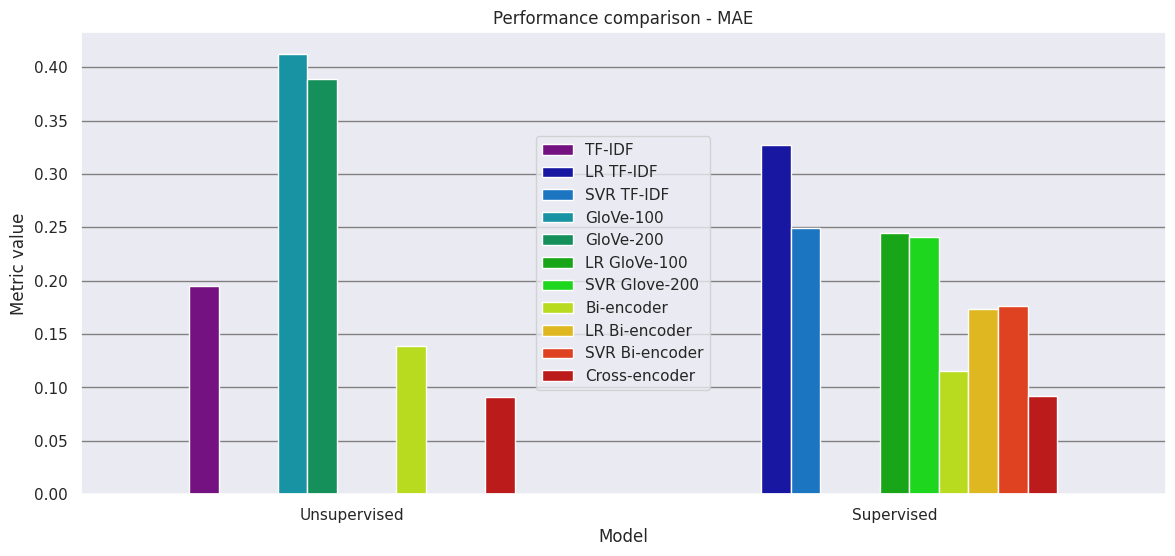

In [ ]:
mae_df = pd.DataFrame(metrics_results['mae'], columns=['model', 'type', 'value'])
plot_results(mae_df, 'Performance comparison - MAE')

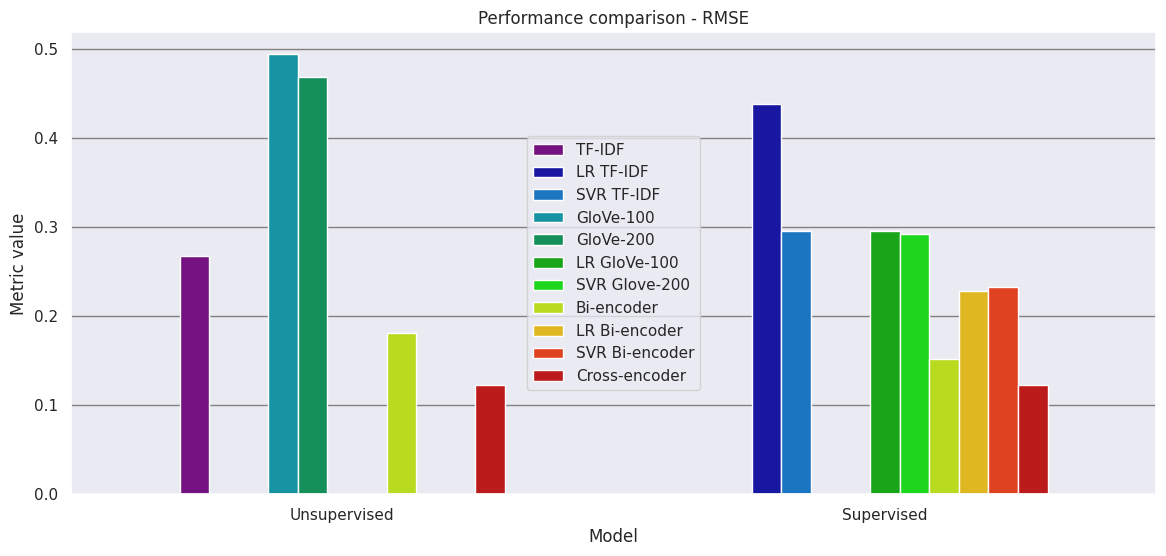

In [ ]:
rmse_df = pd.DataFrame(metrics_results['rmse'], columns=['model', 'type', 'value'])
plot_results(rmse_df, 'Performance comparison - RMSE')

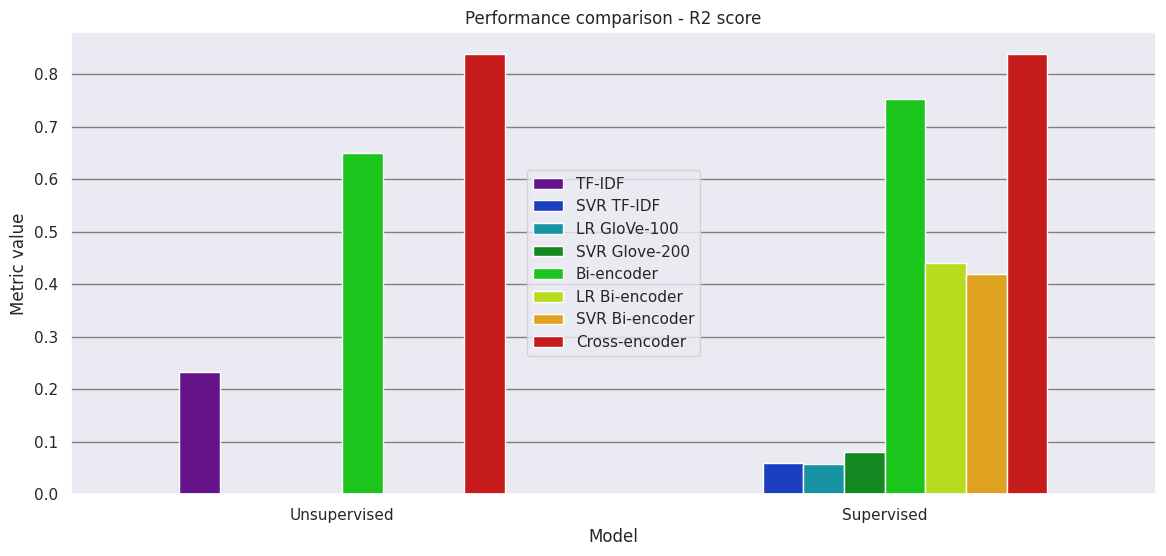

In [ ]:
r2_df = pd.DataFrame(metrics_results['r2'], columns=['model', 'type', 'value'])
plot_results(r2_df, 'Performance comparison - R2 score')

Note that we are plotting only the non-negative R2 scores.

These results are very interesting. Contrary to what we expected, supervised models are not always better than unsupervised ones.
This seems to be related to the fact that traditional ML models cannot handle well the very high dimensionality of the vectorized sentences, and to the quality of the used embeddings. Indeed, the first significant improvement is obtained when switching to DL models, that are able to generate embeddings of a much higher quality and that capture the semantic meaning of the whole sentence.

As expected, fine-tuned DL models vastly outperform any other model. In particular, the considered cross-encoder reaches state-of-the-art performance on the semantic textual similarity task using the STS dataset.

# 3. Extensions

In this section we report the additional investigations we have performed regarding the dataset or our task in general.

## 3.1 Asking ChatGPT

Very common nowadays...

In [ ]:
from ast import literal_eval
from tqdm.notebook import trange
import openai
import tiktoken
import time

ChatGPT is based on GPT 3.5, a large language model trained by OpenAI.
Given that it is a large language model, GPT 3.5 should already have a deep understanding of text.
Meaning that it can already perform NLP tasks without any fine-tuning.

Note that to have GPT 3.5 respond to our queries, we have to provide a valid OpenAI API key.

In [ ]:
openai.api_key  = ""

We need to provide a prompt to GPT 3.5, which is a sentence that will be used by the model to generate a response.

In [ ]:
system_content = """
Your task is to compute the similarity of multiple pair of sentences.
The similarity is a real number that takes range from 0 to 5.
"""

We are instructing the model to compute the similarity between two sentences, following the same guidelines used to annotate the STS dataset, taken from the dataset's [paper](https://aclanthology.org/S17-2001.pdf).

In [ ]:
score_guidelines = """
To determine the score, follow the guidelines delimited by triple backticks. Note that they are not labels, but guidelines. You can answer with any score as long as it is a real number and takes range from 0.0 to 5.0.
```
- Score 5.0: the two sentences are completely equivalent, as they mean the same thing.
- Score 4.0: the two sentences are mostly equivalent, but some unimportant details differ.
- Score 3.0: the two sentences are roughly equivalent, but some important information differs/missing.
- Score 2.0: the two sentences are not equivalent, but share some details.
- Score 1.0: the two sentences are not equivalent, but are on the same topic.
- Score 0.0: the the two sentences are completely dissimilar.
```
"""

In [ ]:
input_format = """
You will receive the multiple pair of sentences in the following format, delimited by triple backticks:
```
[Pair 1]
- "First sentence of the first pair."
- "Second sentence of the first pair."

[Pair 2]
- "First sentence of the second pair."
- "Second sentence of the second pair."

[Pair 3]
- "First sentence of the third pair."
- "Second sentence of the third pair."
```
"""

In [ ]:
few_shots_examples = """
The following are few-shot sample pairs of sentences and their similarity score:

Example 1:
- "A cat is playing a piano."
- "A man is playing a guitar."
Score: 0.6

Example 2:
- "Runners race around a track."
- "Runners compete in a race."
Score: 3.2

Example 3:
- "A person is slicing a tomato."
- "A person is slicing some meat."
Score: 1.75
"""

In [ ]:
output_format = """
Your answer must contain a a list of scores that has one element for each pair received. The first element of the list must be the similarity score of the first pair of sentences, the second element must be the similarity score of the second pair of sentences, and so on and so forth.

An example of an answer is delimited in triple backticks below:
```[ 2.7, 3.2, 1.3 ]```

"""

The following is a helper function to concatenate multiple pair of sentences into a single string, so that we can pass multiple pair of sentences into a single request.

In [ ]:
def concat_sentences(start: int, amount: int = 15) -> str:
    message = "The following are the sentences you need to compute the similarity score for:"
    for i, j in enumerate(range(start, start + amount)):
        message += f"""
[Pair {i + 1}]
- "{df_test['sentence1'][j]}"
- "{df_test['sentence2'][j]}"
"""
    return message

GPT-3.5 can handle at most 4096 tokens in a single request.
We need to use a tokenizer to make sure that the prompt does not exceed the limit.

In [ ]:
tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")

The following functions are used to send the prompt to the model and collect its answer.
Note that we are also checking the number of tokens and raising an exception if it is too large.

In [ ]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0,
    )
    return response.choices[0].message["content"]

In [ ]:
def perform_request(sentences: str) -> list[float]:
    # Concatenate all the strings inside message dictionary
    prompt = system_content + score_guidelines + input_format + few_shots_examples + output_format + sentences

    # Check the number of tokens in the message
    if  len(tokenizer.encode(prompt)) > 3900:
        raise Exception("The number of tokens in the message exceeds the limit.")

    # Perform the request and return the response
    response = get_completion(prompt)
    return literal_eval(response)

Testing has shown that (aside from the constraint on the number of tokens) we cannot pass too many pair of sentences to the model at once otherwise its performance will degrade significantly.

Therefore, we need to send multiple requests to the model and concatenate the results.
In particular, we will send 15 pair of sentences in each request.
Note that we need to check that, for every request, the model returns a consistent output. An exception is raised otherwise.

To allow for a fair comparison with the other models considered, we are asking GPT 3.5. to compute the similarity of the sentences of the test set only.

In [ ]:
pred_scores = list()

In [ ]:
start_sentence = 0
n_sentences = 1365
sentences_per_request = 15

for i in trange(start_sentence, n_sentences, sentences_per_request):
    # Perform the request and save the response
    message = concat_sentences(i, amount=sentences_per_request)
    response = perform_request(message)
    print(f"Similarity of sentences from {i + 1} to {i + sentences_per_request}: {response}")

    # Check that the response is consistent
    if len(response) != sentences_per_request:
        raise Exception("The number of scores returned is not equal to the number of sentences.")
    pred_scores = pred_scores + response
    
    # Wait for 5 seconds to avoid exceeding the rate limit
    time.sleep(5)

We need to send the last request separately since the number of sentences in the test set is not a multiple of 15.

In [ ]:
amount = len(df_test) - n_sentences
message = concat_sentences(n_sentences, amount=amount)
response = perform_request(message)
print(f"Similarity of sentences from {n_sentences + 1} to {n_sentences + amount}: {response}")
if len(response) != amount:
    raise Exception("The number of scores returned is not equal to the number of sentences.")
pred_scores = pred_scores + response

Similarity of sentences from 1366 to 1379: [2.5, 2.8, 3.5, 1.8, 2.2, 1.0, 2.7, 2.2, 2.0, 2.8, 1.2, 2.5, 2.1, 3.2]


We need to rescale the scores returned by GPT 3.5 to make them comparable with the current values in the dataset.

In [ ]:
pred_scores_scaled = np.array(pred_scores) / 5

We can now evaluate the performance and compare it with the ones of the other models.

In [ ]:
evaluate(pred_scores_scaled, 'GPT 3.5', 'Unsupervised')

MAE: 0.16718
RMSE: 0.21633
R2: 0.49688


Results are good, but not as good as the ones obtained with the other models.
We could probably end up with better results with a bit of prompt engineering.

However, the real advantages of this approach are its simplicity and speed. In fact, we were able to complete the task with just a few lines of code and a prompt in natural language.

Note that we consider this as unsupervised since no fine-tuning was performed.

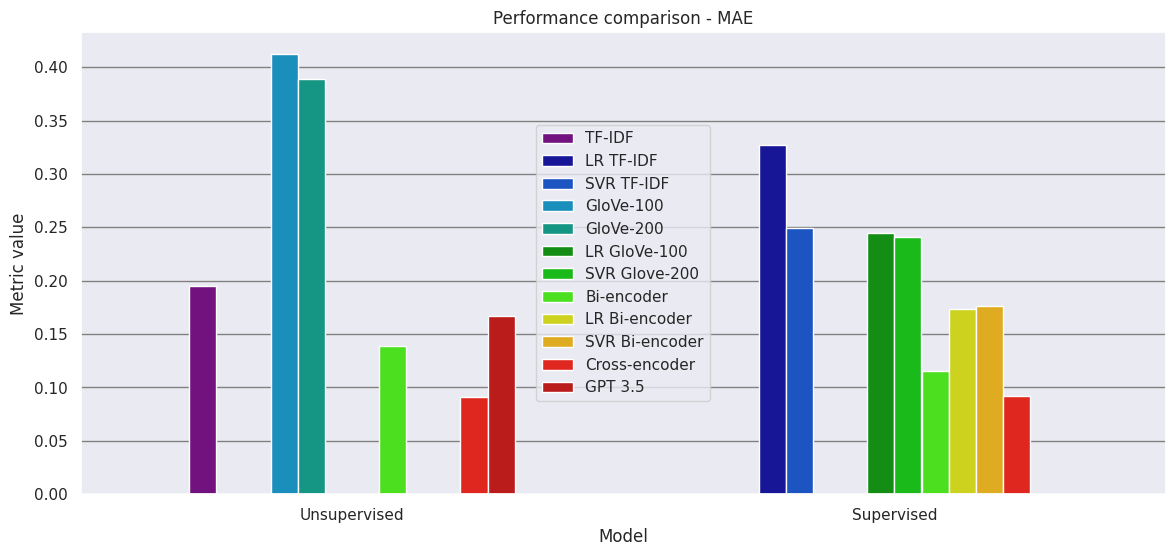

In [ ]:
mae_df = pd.DataFrame(metrics_results['mae'], columns=['model', 'type', 'value'])
plot_results(mae_df, 'Performance comparison - MAE')

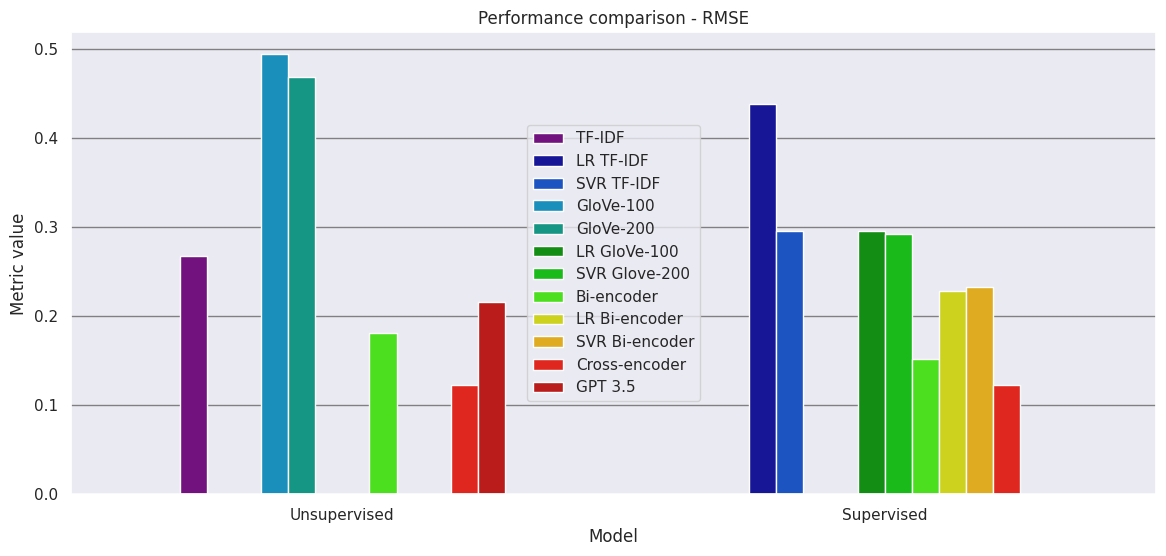

In [ ]:
rmse_df = pd.DataFrame(metrics_results['rmse'], columns=['model', 'type', 'value'])
plot_results(rmse_df, 'Performance comparison - RMSE')

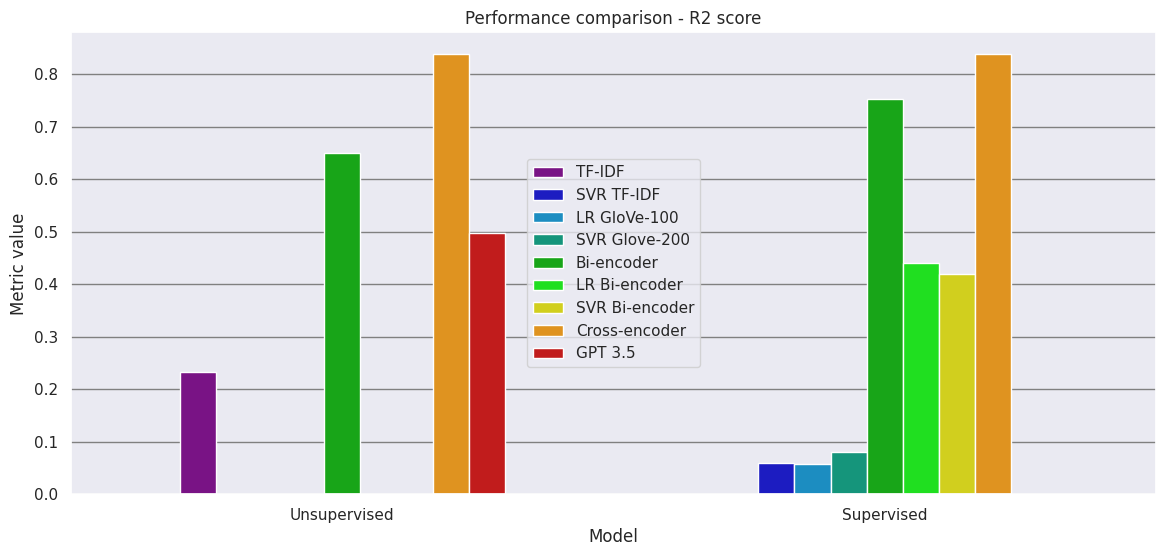

In [ ]:
r2_df = pd.DataFrame(metrics_results['r2'], columns=['model', 'type', 'value'])
plot_results(r2_df, 'Performance comparison - R2 score')

## 3.2 Genre Classification with BERT

As mentioned in section [1.7 Document clustering](#1.7-Document-clustering), when clustering by genre we found a high correlation between the content of the sentences and their source domain. Hence, in this section, we are going to train a classifier to predict the source (caption, news, forum) of a sentence.

In [ ]:
label_names = ['captions', 'news', 'forums'] # these will be our classes

**Data Preprocessing**

First, starting from our cleaned dataframes we obtain a train set (by merging df_train and df_dev) and a test set (df_test).

In [ ]:
df_train_for_genre = pd.concat([df_train, df_dev]).reset_index(drop=True)

For this task we only need to consider a sentence and its genre, thus we concatenate sentences of both `sentence1` and `sentence2` columns and consider them all together. The same we do for the genre, concatenating the genre column twice in order to maintain the correspondence sentence-genre.

For this purpose we initialize two new dataframes that will be populated with the processed data.

In [ ]:
# initializing new dataframes
g_train = pd.DataFrame(columns=['text', 'label'])
g_test = pd.DataFrame(columns=['text', 'label'])

First we concatenate sentences, and their respective genres:

In [ ]:
# concat sentence1 and sentence2
g_train['text'] = pd.concat([df_train_for_genre['sentence1'], df_train_for_genre['sentence2']]).reset_index(drop=True)
g_test['text'] = pd.concat([df_test['sentence1'], df_test['sentence2']]).reset_index(drop=True)

# concat their respective genres
g_train['label'] = pd.concat([df_train_for_genre['genre'], df_train_for_genre['genre']]).reset_index(drop=True)
g_test['label'] = pd.concat([df_test['genre'], df_test['genre']]).reset_index(drop=True)

Then we replace the genre string labels, with integer labels so that the data type applies to the format of the input data requested by the API.

In [ ]:
# rename genres labels to integers
g_train['label'] = g_train['label'].replace({'captions': 0, 'news': 1, 'forums': 2})
g_test['label'] = g_test['label'].replace({'captions': 0, 'news': 1, 'forums': 2})

print(f'N° train sentences: {len(g_train)}')
print(f'N° train sentences: {len(g_test)}')

N° train sentences: 14498
N° train sentences: 2758


Finally, we shuffle the datasets, and reset the indexes:

In [ ]:
# shuffle train and test
g_train = g_train.sample(frac=1).reset_index(drop=True)
g_test = g_test.sample(frac=1).reset_index(drop=True)

**Even out Data**

Performing a check on how many sentences there are for each genre, we obtain the following results:

Text(0.5, 1.0, 'Test')

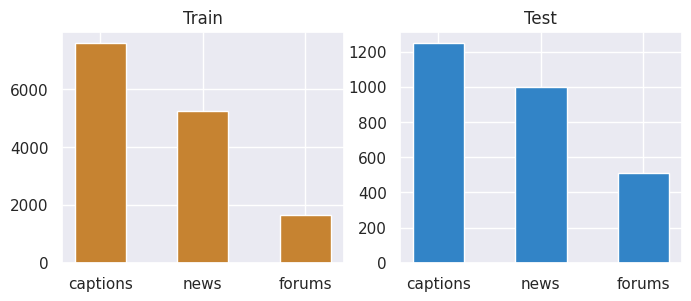

In [ ]:
sns.set_theme()
width = 0.7
_, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].bar(label_names, g_train['label'].value_counts(), color="#c68331", width=0.5)
axs[0].set_title('Train')

axs[1].bar(label_names, g_test['label'].value_counts(), color="#3284c7", width=0.5)
axs[1].set_title('Test')

We notice that the distribution of sentences on genres is not uniform: *captions* and *news* are much more numerous than *forums*.

Thus, we uniform all classes, cutting off exceeding captions and news, by:
- collecting separately captions, news and forums
- cutting off sets at the number of sentences of the least present genre
- rejoining captions, news and forums

Uniforming train set:

In [ ]:
# collect separately captions, news and forums
train_captions = g_train.loc[g_train['label']==0].reset_index(drop=True)
train_news = g_train.loc[g_train['label']==1].reset_index(drop=True)
train_forums = g_train.loc[g_train['label']==2].reset_index(drop=True)

# cut off at the number of sentences of the least present genre
train_captions = train_captions[:g_train['label'].value_counts()[2]]
train_news = train_news[:g_train['label'].value_counts()[2]]
train_forums = train_forums[:g_train['label'].value_counts()[2]]

# rejoin captions, news and forums
g_train = pd.concat([train_captions, train_news, train_forums]).reset_index(drop=True)
g_train = g_train.sample(frac=1).reset_index(drop=True) # shuffle

Uniforming test set:

In [ ]:
# collect separately captions, news and forums
test_captions = g_test.loc[g_test['label']==0].reset_index(drop=True)
test_news = g_test.loc[g_test['label']==1].reset_index(drop=True)
test_forums = g_test.loc[g_test['label']==2].reset_index(drop=True)

# cut off at the number of sentences of the least present genre
test_captions = test_captions[:g_test['label'].value_counts()[2]]
test_news = test_news[:g_test['label'].value_counts()[2]]
test_forums = test_forums[:g_test['label'].value_counts()[2]]

# rejoin captions, news and forums
g_test = pd.concat([test_captions, test_news, test_forums]).reset_index(drop=True)
g_test = g_test.sample(frac=1).reset_index(drop=True) # shuffle

Here is a plot of the new distribution of the classes:

Text(0.5, 1.0, 'Test')

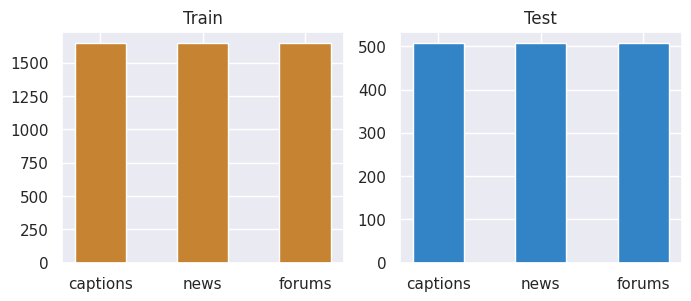

In [ ]:
width = 0.7
_, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].bar(label_names, g_train['label'].value_counts(), color="#c68331", width=0.5)
axs[0].set_title('Train')

axs[1].bar(label_names, g_test['label'].value_counts(), color="#3284c7", width=0.5)
axs[1].set_title('Test')

Now we have uniform distribution of the classes.

**Training the model**

First we install and import libraries:

We'll use `transformers` library that provides APIs and tools to easily download and train state-of-the-art pretrained models, such as BERT. 

In [ ]:
!pip3 install -q transformers==4.28.0 datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 51.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.0 MB/s eta 0:00:00


In [ ]:
!pip -q install ktrain

In [ ]:
!pip3 uninstall -q flask
!pip3 install -q eli5

Found existing installation: Flask 2.2.4
Uninstalling Flask-2.2.4:
  Would remove:
    /usr/local/bin/flask
    /usr/local/lib/python3.10/dist-packages/Flask-2.2.4.dist-info/*
    /usr/local/lib/python3.10/dist-packages/flask/*
Proceed (Y/n)? y
  Successfully uninstalled Flask-2.2.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import torch

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

The pretrained model we're going to use is `bert-base-uncased`, a BERT model trained on a large corpus of English data, that, among many other tasks, can be used for an efficient text classification.

In [ ]:
model_name = 'bert-base-uncased'

**Load transformer**:

We first load the transformer, setting the model to be `bert-base-uncased` and the classes to be the three genres.

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
bert = bert.to(device) # move to GPU

In [ ]:
for param in bert.parameters():
    print(param.size(), param.requires_grad) # check which parameters are trainable

torch.Size([30522, 768]) True
torch.Size([512, 768]) True
torch.Size([2, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([3072, 768]) True
torch.Size([3072]) True
torch.Size([768, 3072]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([3072, 768]) True
torch.Size([3072]) True
torch.Size([768, 3072]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768]) True
torch.Size([768, 768]) True
torch.Size([768]) True
torch.Size([768, 

**Load tokenizer**:

Then we load the tokenizer, that we'll use to transform our sentences into sets of tokens.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

 Before training the model, we need to structure training and test data, as required by the pretrained model interface, using the transformer's data set API by:

- converting the pandas Dataframe into the Dataset format required by the API

In [ ]:
g_train_data = Dataset.from_pandas(g_train)
g_test_data = Dataset.from_pandas(g_test)

- creating a DatasetDict that contains all the splits of the data set

In [ ]:
g_data = DatasetDict()
g_data['train'] = g_train_data
g_data['test'] = g_test_data

Then we use the tokenizer to convert the input strings into sequences of tokens:

In [ ]:
def tokenize_function(sample):
    return tokenizer(sample["text"], padding='max_length', truncation=True)

g_tokenized_data = g_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

Map:   0%|          | 0/1524 [00:00<?, ? examples/s]

Here an example of sentence tokenization:

In [ ]:
print(f'Sentence:')
print(g_train['text'][0])
print(f'Tokens IDs:')
print(tokenizer(g_train['text'][0]).input_ids) # sequence of tokens id
print(f'Vocabulary size: {len(tokenizer.vocab)}\n')

s0 = g_train['text'][0]
s0_enc = tokenizer(g_train['text'][0]).input_ids
vocab_terms = list(tokenizer.vocab.keys())
vocab_index = list(tokenizer.vocab.values())
print("Sentence: "+ s0)
print("Tokenized sentence:  ", [vocab_terms[vocab_index.index(i)] for i in s0_enc])

Sentence:
A man puts a knife in a vice.
Tokens IDs:
[101, 1037, 2158, 8509, 1037, 5442, 1999, 1037, 3580, 1012, 102]
Vocabulary size: 30522

Sentence: A man puts a knife in a vice.
Tokenized sentence:   ['[CLS]', 'a', 'man', 'puts', 'a', 'knife', 'in', 'a', 'vice', '.', '[SEP]']


First we need to set up for training starting by preparing the **training arguments**:

In [ ]:
training_args = TrainingArguments(
    "genres_trainer",
    optim="adamw_torch",
    per_device_train_batch_size=16
)

Then we build the **trainer**, setting the pretrained model, the training arguments, and the tokenized train and test sets:

In [ ]:
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=g_tokenized_data['train'],
    eval_dataset=g_tokenized_data['test'],
)

In the end we can start the **training** process:

In [ ]:
trainer.train()

TrainOutput(global_step=930, training_loss=0.06462469203497774, metrics={'train_runtime': 1302.1022, 'train_samples_per_second': 11.405, 'train_steps_per_second': 0.714, 'total_flos': 3907234253260800.0, 'train_loss': 0.06462469203497774, 'epoch': 3.0})

Once we've trained it, we evaluate the model on our test data:

In [ ]:
trainer.evaluate()

{'eval_loss': 0.07573330402374268,
 'eval_runtime': 46.2684,
 'eval_samples_per_second': 32.938,
 'eval_steps_per_second': 4.128,
 'epoch': 3.0}

Then we get the predictions on test data (this returns predicted logits):

In [ ]:
preds = trainer.predict(g_tokenized_data['test'])
preds

PredictionOutput(predictions=array([[-3.187519 ,  6.2301164, -2.8321853],
       [-3.415536 ,  6.168304 , -2.600588 ],
       [-3.061329 ,  5.9719596, -2.854739 ],
       ...,
       [-5.1211443,  0.8644467,  3.8545902],
       [-3.3023362,  5.8351445, -2.4903522],
       [-3.07633  , -2.6107879,  5.8590016]], dtype=float32), label_ids=array([1, 1, 1, ..., 1, 1, 2]), metrics={'test_loss': 0.07573330402374268, 'test_runtime': 48.5347, 'test_samples_per_second': 31.4, 'test_steps_per_second': 3.935})

And starting from those we get labels predictions using the `argmax` operator:

In [ ]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()
y_pred

array([1, 1, 1, ..., 2, 1, 2])

We then display the *classification report*, which shows a very good performance of our model.

In [ ]:
print(classification_report(g_test['label'], y_pred, target_names=label_names))

              precision    recall  f1-score   support

    captions       1.00      0.99      1.00       508
        news       0.99      0.98      0.98       508
      forums       0.98      0.99      0.99       508

    accuracy                           0.99      1524
   macro avg       0.99      0.99      0.99      1524
weighted avg       0.99      0.99      0.99      1524



Also, through the *confusion matrix*, we can see that the model made very few mistakes in predicting the genre of the sentences.

Text(30.0, 0.5, 'Predicted labels')

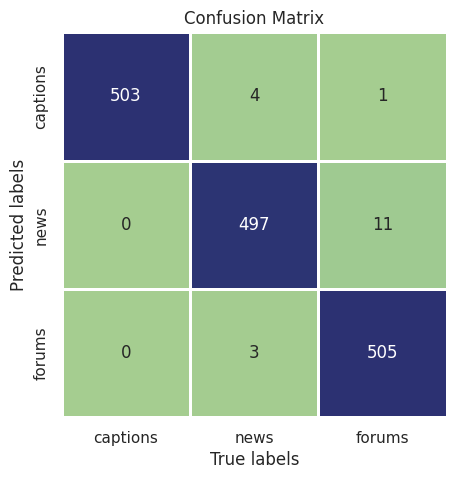

In [ ]:
cm = confusion_matrix(g_test['label'], y_pred)
_, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, cbar=False, fmt="d", linewidths=2, square=True, xticklabels=label_names, yticklabels=label_names, ax=ax, cmap="crest")
ax.set_title('Confusion Matrix')
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')

**Saving model**

In [ ]:
bert.save_pretrained('models/genre_model')

In [ ]:
# !zip -r genre_model.zip "models/genre_model"

**Using the model**

Now we can load and use our model to predict the genre of sentences.

In [ ]:
genre_bert = AutoModelForSequenceClassification.from_pretrained('models/genre_model').to(device)

This is a function we'll use to make the prediction for a sentence with our model:

In [ ]:
@torch.no_grad()
def predict(text):
    # tokenize the sentence
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    # predict with the model
    outputs = genre_bert(**input_encodings)

    # integer label to string label
    lbl = label_names[torch.argmax(outputs.logits).item()]

    return lbl

This is a function we'll use to get the prediction’s probabilities:

In [ ]:
@torch.no_grad()
def predict_proba(text):
    # tokenize the sentence
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    # predict with the model
    outputs = genre_bert(**input_encodings)

    proba = torch.softmax(outputs.logits, dim=1).cpu().squeeze().numpy() # using softmax


    return dict(zip(label_names, proba))

Here we recall the results that we obtain with the prediction on our test set:

In [ ]:
label_pred = g_test['text'].apply(lambda x : list(label_names).index(predict(x)))

The *classification report* shows a good performance of our model.

In [ ]:
print(classification_report(g_test['label'], label_pred, target_names=label_names))

              precision    recall  f1-score   support

    captions       1.00      1.00      1.00       508
        news       0.99      0.98      0.98       508
      forums       0.98      0.99      0.98       508

    accuracy                           0.99      1524
   macro avg       0.99      0.99      0.99      1524
weighted avg       0.99      0.99      0.99      1524



And with the *confusion matrix*, we see that it made few mistakes.

Text(30.0, 0.5, 'Predicted labels')

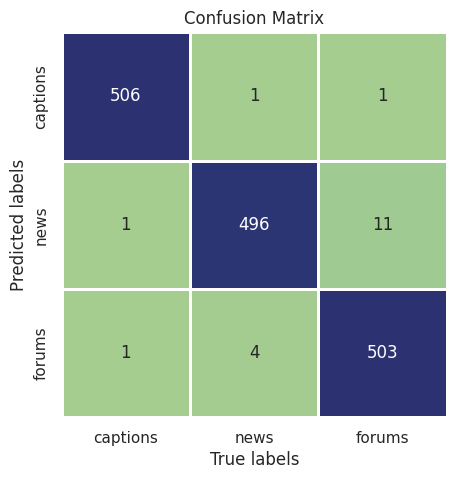

In [ ]:
cm = confusion_matrix(g_test['label'], label_pred)
_, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, cbar=False, fmt="d", linewidths=2, square=True, xticklabels=label_names, yticklabels=label_names, ax=ax, cmap="crest")
ax.set_title('Confusion Matrix')
ax.set_xlabel('True labels')
ax.set_ylabel('Predicted labels')

As last, we can try to predict the genre of some more sentence's samples:

Here a list of some sentences and their genre.

In [ ]:
new_sentences = [
    ("A guy with a blue shirt walking in a park",	"captions"),
    ("Anger over airports' passport e-gates not working", "news"),
    ("The guy with a blue shirt is walking",	"captions"),
    ("Can anyone help with this please? I can't find an answer on Google.",	"forums"),
    ("Passenger who opened plane door mid-air arrested", "news"),
    ("Hey there, I'm currently designing a new application!",	"forums"),
    ("Elon Musk: I will say what I want even if it costs me",	"news"),
]

We perform the prediction on the sentences, and extract the probabilities:

In [ ]:
new_pred = [predict(x) for x in list(dict(new_sentences).keys())] # new_sentences['sentence'].apply(lambda x : predict(x))
new_prob = [predict_proba(x) for x in list(dict(new_sentences).keys())] # new_sentences['sentence'].apply(lambda x : predict_proba(x))

Finally, we can compare the original target genre with the predicted one, and see the probability of the predictions, for each sentence:

In [ ]:
for i in range(len(new_sentences)):
  print(f'--------------------------------------------------------------------------------------------------------------------------')
  print(f'Sentence: {new_sentences[i][0]}')
  print(f'Genre: {new_sentences[i][1]}\n')
  print(f'Predicted Genre: {new_pred[i]}')
  print(f'Probability: {new_prob[i]}')
  print('--------------------------------------------------------------------------------------------------------------------------\n')

--------------------------------------------------------------------------------------------------------------------------
Sentence: A guy with a blue shirt waliking in a park
Genre: captions

Predicted Genre: captions
Probability: {'captions': 0.9998105, 'news': 8.2485974e-05, 'forums': 0.000106981825}
--------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------
Sentence: Anger over airports' passport e-gates not working
Genre: news

Predicted Genre: news
Probability: {'captions': 5.6794062e-05, 'news': 0.999782, 'forums': 0.00016115968}
--------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------------
Sentence: The guy with

## 3.3 Evaluation with another dataset

In this last section we use the Bi-encoder and CrossEncoder models we previously trained (that are the ones with whom we got the best performance) to predict the score of pairs of sentences of a new **unseen dataset**.

The dataset we'll use is the __[SICK](https://marcobaroni.org/composes/sick.html#:~:text=Creative%20Commons%20Attribution-NonCommercial-ShareAlike%20license)__ dataset. 
This dataset contains sentences' pairs that were annotated for relatedness, by humans, by means of crowdsourcing techniques.
The sentence relatedness score is on a 5-point rating scale, i.e. in a range $[1, 5]$, and quantifies the degree of semantic relatedness between sentences.

In [ ]:
path_sick = 'SICK/SICK.txt'

Load the dataset:

In [ ]:
df_sick = pd.read_csv(path_sick, sep='\t', usecols=range(5), header=0, quoting=csv.QUOTE_NONE, encoding='UTF-8')

Once we've imported the dataset we need to do some pre-processing on it.

First we rename columns:

In [ ]:
df_sick.rename(columns={'pair_ID': 'id', 'sentence_A': 'sentence1', 'sentence_B': 'sentence2', 'entailment_label': 'ent', 'relatedness_score': 'score'}, inplace=True)

We remove rows where entailment is *contradiction*, because they're not suited to our model's purpose.

In [ ]:
df_sick = df_sick[df_sick['ent'] != 'CONTRADICTION']

Then we can drop the columns we don't need.

In [ ]:
df_sick = df_sick.drop(['id'], axis=1) # drop id column

In [ ]:
df_sick = df_sick.drop(['ent'], axis=1) # drop ent column

In [ ]:
df_sick.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8416 entries, 0 to 9839
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentence1  8416 non-null   object 
 1   sentence2  8416 non-null   object 
 2   score      8416 non-null   float64
dtypes: float64(1), object(2)
memory usage: 263.0+ KB


As we did with our original dataset, we normalize the score from being in the range $[1, 5]$, to being in the range $[0, 1]$ using `MinMaxScaler` from `scikit-learn`.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_sick['score'] = scaler.fit_transform(df_sick[['score']])
df_sick

sentence1  \
0     A group of kids is playing in a yard and an ol...   
1     A group of children is playing in the house an...   
2     The young boys are playing outdoors and the ma...   
4     The kids are playing outdoors near a man with ...   
5     There is no boy playing outdoors and there is ...   
...                                                 ...   
9835  A man is in a parking lot and is playing tenni...   
9836                   Someone is boiling okra in a pot   
9837  The man is singing heartily and playing the gu...   
9838        A man in blue has a yellow ball in the mitt   
9839               Three dogs are resting on a sidewalk   

                                              sentence2  score  
0     A group of boys in a yard is playing and a man...  0.875  
1     A group of kids is playing in a yard and an ol...  0.550  
2     The kids are playing outdoors near a man with ...  0.925  
4     A group of kids is playing in a yard and an ol...  0.600  
5     A group of kids is playing in a yard and an ol...  0.575  
...                                                 ...    ...  
9835  The snowboarder is leaping fearlessly over whi...  0.000  
9836                   The man is not playing the drums  0.000  
9837  A bicyclist is holding a bike over his head in...  0.000  
9838                      A man is jumping rope outside  0.050  
9839         The woman with a knife is slicing a pepper  0.000  

[8416 rows x 3 columns]

In [ ]:
df_sick['score'].describe()

count    8416.000000
mean        0.628496
std         0.270932
min         0.000000
25%         0.475000
50%         0.675000
75%         0.850000
max         1.000000
Name: score, dtype: float64

Just to have an idea of the sentences we're dealing with, we compute the average number of characters per sentence. 

In [ ]:
s1_len = df_sick['sentence1'].apply(lambda x : len(str(x)))
s2_len = df_sick['sentence2'].apply(lambda x : len(str(x)))
print(f'Average n° of characters (1): {s1_len.mean()}')
print(f'Average n° of characters (2): {s2_len.mean()}')

Average n° of characters (1): 47.23716730038023
Average n° of characters (2): 46.030774714828894


In [ ]:
!pip install -q sentence_transformers

### 3.3.1 Bi-encoder

In [ ]:
from sentence_transformers import SentenceTransformer

First we use our pretrained bi-encoder model `all-mpnet-base-v2-fine-tuned` to predict the similarity of the pairs of sentences in SICK dataset.

In [ ]:
bi_enc_tuned = SentenceTransformer("models/all-mpnet-base-v2-fine-tuned")

In [ ]:
s1_test = bi_enc_tuned.encode(list(df_sick['sentence1']))
s2_test = bi_enc_tuned.encode(list(df_sick['sentence2']))

In [ ]:
pred_scores = cosine_similarity(s1_test, s2_test).diagonal()

Then we evaluate the results of the prediction:

In [ ]:
print("MAE: ", mean_absolute_error(df_sick['score'], pred_scores))
print("RMSE: ", np.sqrt(mean_squared_error(df_sick['score'], pred_scores)))
print("R2: ", r2_score(df_sick['score'], pred_scores))

MAE:  0.10465798618136002
RMSE:  0.1409542746109971
R2:  0.7292996810786097


The model performs quite well, even if a bit worse compared to what we obtained on STS test dataset. This could be for the following reasons: 
- the rationale behind the score assignment of the SICK dataset might be different from the one of STS dataset,
- the sentences of SICK dataset are all image's captions, but, given our train dataset, captions are just a part of what our model has learned, so it is possible that on this large dataset of captions the model is not always as accurate.

Overall the performance is good.

### 3.3.2 Cross-encoder

In [ ]:
from sentence_transformers import CrossEncoder

Now we use our pretrained cross-encoder model `stsb-roberta-large-fine-tuned` to predict the similarity of the pairs of sentences in SICK dataset.

In [ ]:
sentence_pairs = df_sick[['sentence1', 'sentence2']].to_numpy().tolist()

In [ ]:
cross_enc_tuned = CrossEncoder("models/stsb-roberta-large-fine-tuned")

In [ ]:
pred_scores = cross_enc_tuned.predict(sentence_pairs, show_progress_bar=True)

Batches:   0%|          | 0/263 [00:00<?, ?it/s]

Then we evaluate the results of the prediction:

In [ ]:
print("MAE: ", mean_absolute_error(df_sick['score'], pred_scores))
print("RMSE: ", np.sqrt(mean_squared_error(df_sick['score'], pred_scores)))
print("R2: ", r2_score(df_sick['score'], pred_scores))

MAE:  0.10400461899911678
RMSE:  0.1432065394989349
R2:  0.7205796924155284


As with the bi-encoder model, the performance on this dataset is a bit worse than the one on STS test dataset. Although, with the same considerations of before, overall the results are good.